#  Data Foundation Building

This is prototyping notebook of multiple python files.

For easy debugging and fast coding development of building foundation of data pipelining, this contains detailed notes / to-do list.

This is added in my repo so that I can remind myself of what/why I coded like this.

If there is anyone who wants to follow my work, this will be great starting point.

## 0. Importing Necessary Libraries

In [3]:
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Optional, Dict
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Data Collection
**Goal**: Gather high-quality, clean, and consistent time series data that covers both price and macroeconomic context

**Kinds of Data**
- Market Data Sources: S&P500
- Macroeconomic Data:
  - real GDP (will be used as GDP growth rate)
  - Unemployment Rate
  - Interest rates (Fed Funds Rate, yield curve)
  - CPI for inflation rate (if possible, add inflation expectations)
  - VIX index (market volatility)
  - Government fiscal data (debt levels, spending, tax receipts, fiscal balance)
  - Trade Balance of US
  - Balance of payments (if feasible)
- Target Stock Data: AMD (as an example)

**Resolution**: Choose daily (or higher frequency if available)

**Storage**: Save raw datasets in csv

**API / Providers**: Yahoo Finance, FRED



In [6]:
# ===============================
# Configuration
# ===============================
MARKET_TICKER = "^GSPC"
TARGET_TICKER = "AMD"
START_DATE = "1992-01-01"
END_DATE = "2019-12-31"

DATA_DIR = "FinD_Generator/data/raw"
os.makedirs(DATA_DIR, exist_ok=True)

GRAPH_DIR = 'FinD_Generator/image/graph/'
os.makedirs(GRAPH_DIR, exist_ok=True)

FRED_DAILY_IDS = {
#        "VIXCLS": "vix",          # Volatility Index (daily)
        "T10Y2Y": "yield_curve",  # Yield Curve (daily)
}

FRED_MONTHLY_IDS = {
    "CPIAUCSL": "cpi",            # Consumer Price Index (monthly)
    "UNRATE": "unemployment",     # Unemployment Rate (monthly)
    "FEDFUNDS": "interest_rate",  # Interest Rates (monthly)
    "BOPGSTB": "trade_balance",   # US Trade Balance (monthly)
}

FRED_QUARTERLY_IDS = {
    "GDPC1": "gdp",                           # Real GDP (quarterly)
    "GFDEBTN": "gov_debt",                    # Debt Level (quarterly)
    "M318501Q027NBEA": "gov_fiscal_balance",  # US Government Fiscal Balance (quarterly)
    "W006RC1Q027SBEA": "tax_receipts",        # US Government Tax Receipts (quarterly)
    "FGEXPND": "gov_spending"                 # US Government Spending (quarterly)
}

# ===============================
# Helper Functions
# ===============================
def save_csv(df: pd.DataFrame, filename: str, dir: str=DATA_DIR):
    """Save DataFrame to CSV with basic logging."""
    path = os.path.join(dir, filename)
    df.to_csv(path, index=False)
    print(f"✅ Saved {filename} ({len(df)} rows)")

def rename_price_to_dfname(df: pd.DataFrame) -> pd.DataFrame:
    # Step 1 — Flatten MultiIndex (if it exists)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(map(str, col)).strip() for col in df.columns]

    # Step 2 — Replace 'Price_' prefix with the DataFrame’s name
    if df.name:  # make sure df.name exists
        df.columns = [col.replace("Price_", f"{df.name}_") for col in df.columns]

    return df

# ===============================
# 1. YFinance Data Collector
# ===============================
def fetch_yf_data(ticker: str, start: str, end: str) -> pd.DataFrame:
    """Fetch data from Yahoo Finance and return a DataFrame."""
    data = yf.download(ticker, start=start, end=end)
    data.columns = data.columns.get_level_values(0)
    if data.empty:
        raise ValueError(f"No data returned for ticker {ticker}")
    data = data.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })
    data = data.reset_index()
    return data[['Date', 'open', 'high', 'low', 'close', 'volume']]

# ===============================
# 2. FRED Data Collector
# ===============================
def fetch_macro_data(id: dict, start: str, end: str) -> pd.DataFrame:
  """Fetch data from FRED and return a DataFrame."""
  fred_df = web.DataReader(list(id.keys()), "fred", start, end)
  fred_df = fred_df.rename(columns=id)
  fred_df = fred_df.reset_index()
  fred_df = fred_df.rename(columns={"DATE": "Date"})
  return fred_df

# ===============================
# 3. Data Collection
# ===============================
market_df = fetch_yf_data(MARKET_TICKER, START_DATE, END_DATE)
target_df = fetch_yf_data(TARGET_TICKER, START_DATE, END_DATE)

daily_macro_df = fetch_macro_data(FRED_DAILY_IDS, START_DATE, END_DATE)
monthly_macro_df = fetch_macro_data(FRED_MONTHLY_IDS, START_DATE, END_DATE)
quarterly_macro_df = fetch_macro_data(FRED_QUARTERLY_IDS, START_DATE, END_DATE)

# Fetch VIX data seperately from yfinance since FRED provides VIX data with many null values
vix_df = yf.download("^VIX", interval='1mo', start=START_DATE, end=END_DATE)
vix_df.columns = vix_df.columns.get_level_values(0)
vix_df = vix_df.reset_index()
vix_df = vix_df.rename(columns={
    'Datetime': 'Date',
    'Close': 'vix'})
vix_df = vix_df[['Date', 'vix']]

# Combine vix_df with monthly
daily_macro_df = pd.concat([daily_macro_df, vix_df[['vix']]], axis=1)

# Create empty df for future purpose
macro_df = pd.DataFrame()

# Name each df
market_df.name = 'market'
target_df.name = 'target'
daily_macro_df.name = 'daily_macro'
monthly_macro_df.name = 'monthly_macro'
quarterly_macro_df.name = 'quartery_macro'
macro_df.name = 'macro'

# Flatten MultiIndex columns if present
rename_price_to_dfname(market_df)
rename_price_to_dfname(target_df)

save_csv(target_df, f"{target_df.name}.csv")
save_csv(market_df, f"{market_df.name}.csv")
save_csv(daily_macro_df, f"{daily_macro_df.name}.csv")
save_csv(monthly_macro_df, f"{monthly_macro_df.name}.csv")
save_csv(quarterly_macro_df, f"{quarterly_macro_df.name}.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Saved target.csv (7052 rows)
✅ Saved market.csv (7052 rows)
✅ Saved daily_macro.csv (7305 rows)
✅ Saved monthly_macro.csv (336 rows)
✅ Saved quartery_macro.csv (112 rows)


## 2. Exploratory Data Analysis
**Goal**: Understand data characteristics and identify preprocessing requirements

**Check for**:
- Data coverage and frequency alignment across all series
- Missing values and irregular timestamps
- Outliers or anomalous spikes
- Seasonality and trends (especially for macro data)
- Correlations between features (e.g., VIX vs. returns)

**Visualizations**:
- Line plots of key variables over time
- Correlation heatmaps
- Rolling statistics (mean, volatility)

**Statistical summaries**:
- Stationarity checks (Augmented Dickey–Fuller test)
- Distribution plots of returns

### 2-1. Brief Skimming

In [5]:
# ===============================
# Data Skimming
# ===============================
market_df.head()
#market_df.info()

target_df.head()
#target_df.info()

daily_macro_df.head()
#daily_macro_df.info()

monthly_macro_df.head()
#monthly_macro_df.info()

quarterly_macro_df.head()
#quarterly_macro_df.info()

,Date,gdp,gov_debt,gov_fiscal_balance,tax_receipts,gov_spending
0,1992-01-01,10236.435,3881288,-114.114,627.451,1458.390
1,1992-04-01,10347.429,3984656,-30.013,637.932,1476.444
2,1992-07-01,10449.673,4064621,-62.638,642.804,1498.726
3,1992-10-01,10558.648,4177009,-120.334,673.510,1521.869
4,1993-01-01,10576.275,4230580,-63.127,656.938,1522.365


In [ ]:
# ===============================
# Summary Statistics
# ===============================
#market_df.describe()
#target_df.describe()
#daily_macro_df.describe()
#monthly_macro_df.describe()
quarterly_macro_df.describe()

,Date,gdp,gov_debt,gov_fiscal_balance,tax_receipts,gov_spending
count,112,112.000000,1.120000e+02,112.000000,112.000000,112.000000
mean,2005-11-15 10:30:00,15555.531527,1.069096e+07,-112.480634,1363.588304,2848.335929
min,1992-01-01 00:00:00,10236.435000,3.881288e+06,-481.715000,627.451000,1458.390000
25%,1998-12-09 00:00:00,13284.615250,5.632639e+06,-185.444500,1056.999500,1813.885500
50%,2005-11-16 00:00:00,16202.939500,8.270784e+06,-83.072500,1294.399000,2689.001500
75%,2012-10-24 00:00:00,17532.989000,1.650909e+07,-19.699500,1650.442000,3788.005500
max,2019-10-01 00:00:00,20985.448000,2.320138e+07,211.241000,2173.772000,4796.274000
std,NaN,2943.581711,5.995757e+06,147.945785,435.856616,1042.715128


In [ ]:
# ===============================
# Missing Value Checks
# ===============================
#market_df.isnull().sum()         # no Null values in market_df
#target_df.isnull().sum()         # no Null values in target_df
#monthly_macro_df.isnull().sum()  # no Null values in monthly_macro_df

daily_macro_df.isnull().sum()
quarterly_macro_df.isnull().sum()

,0
Date,0
gdp,0
gov_debt,0
gov_fiscal_balance,4
tax_receipts,0
gov_spending,0


#### Notes after brief skimming

Monthly / quarterly data have dates per month / quarter.

Market, target, monthly dataframes have no null values.
- which is good since we don't have to fill in the gaps
- for macroeconomic data, setting a frequency to monthly will be a good choice.

In daily_macro_df, yield_curve has 354 missing values.

In quarterly_macro_df, fiscal_balance has 4 missing values.

All date data have a datatype of date64, no need of further processing.

### 2-2. Rolling Stats

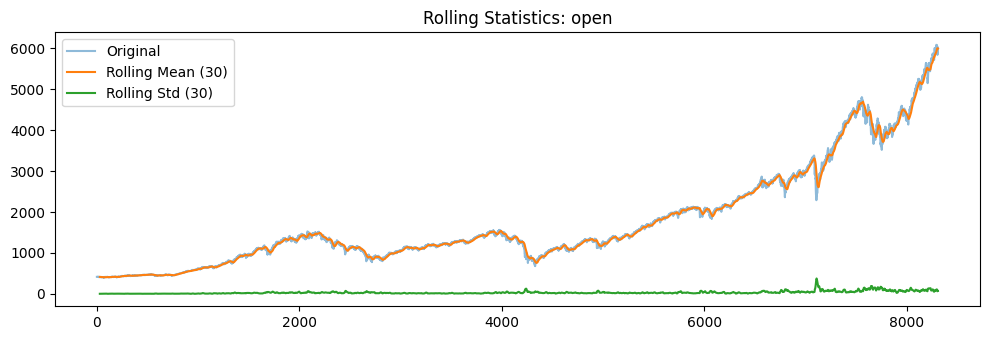

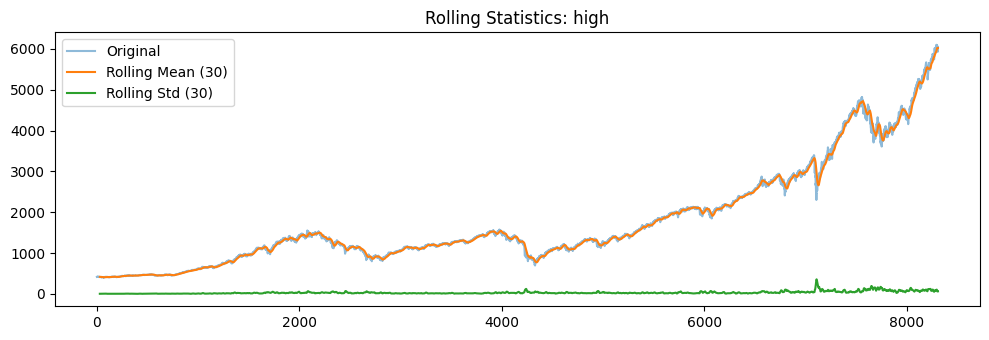

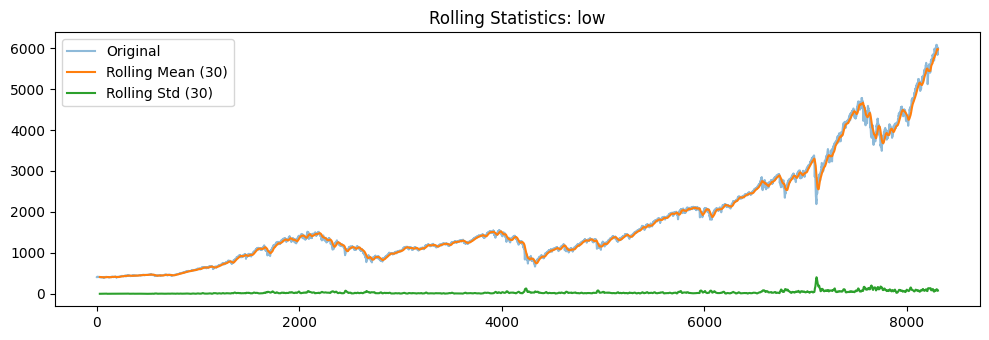

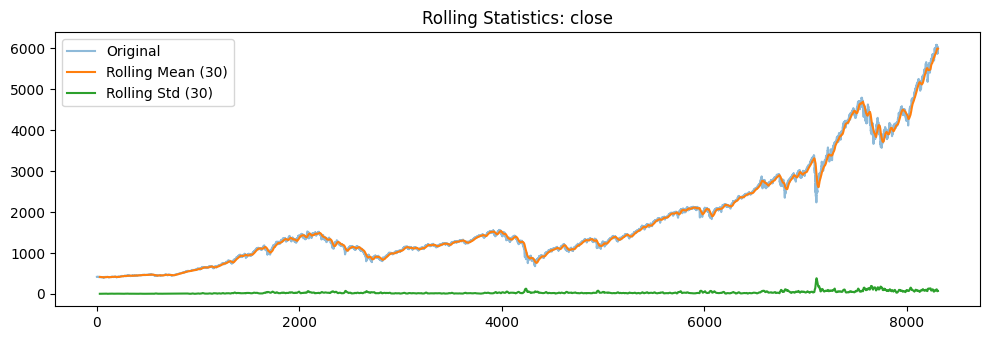

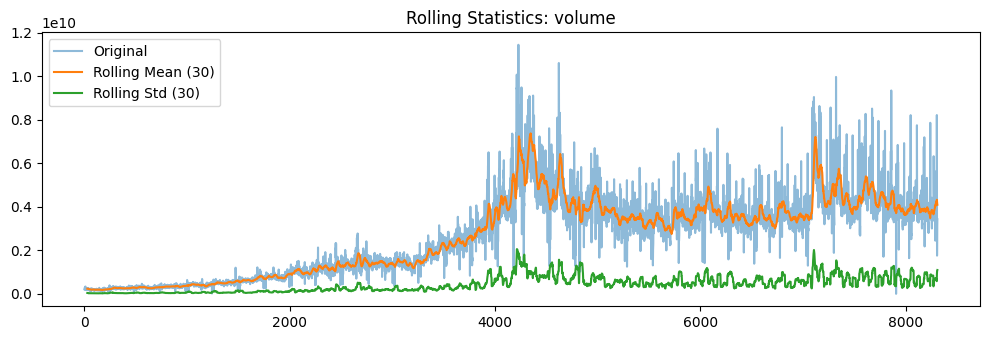

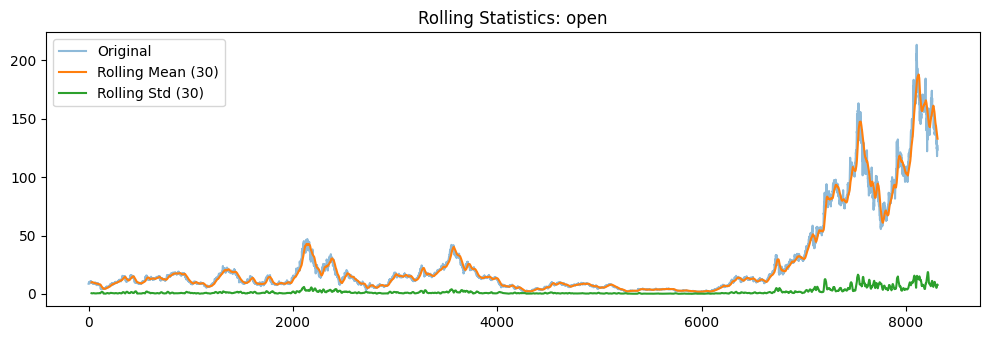

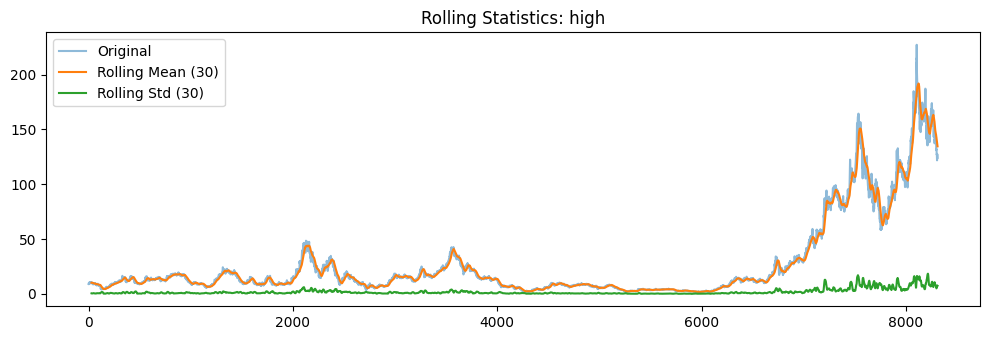

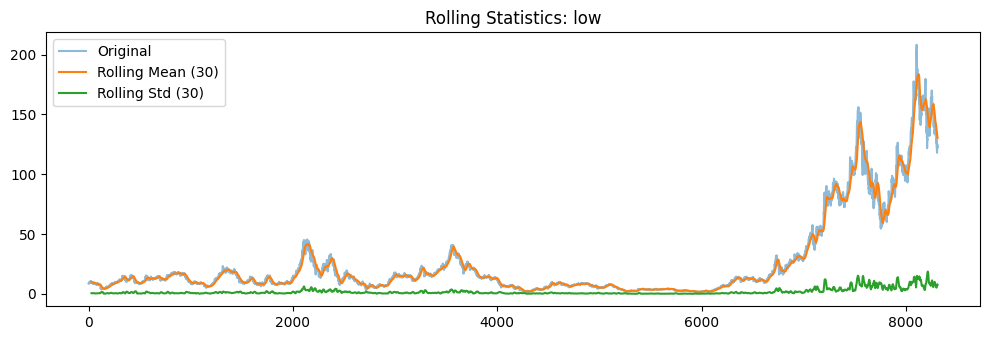

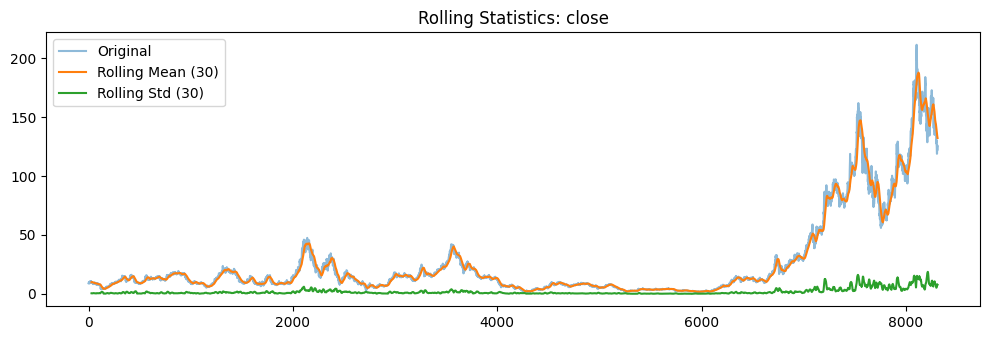

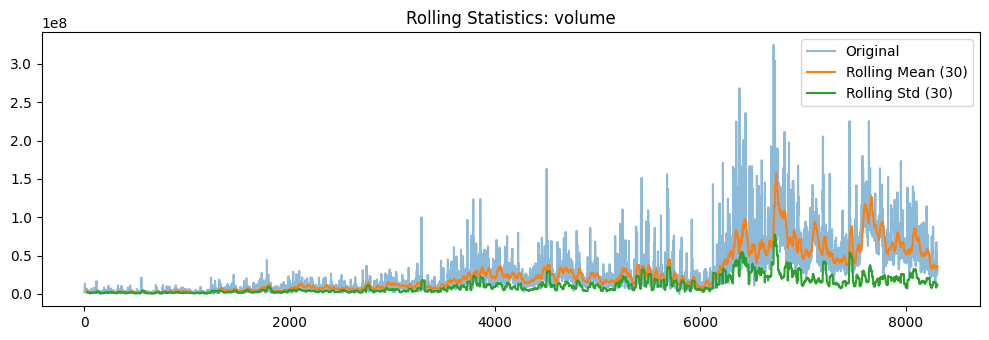

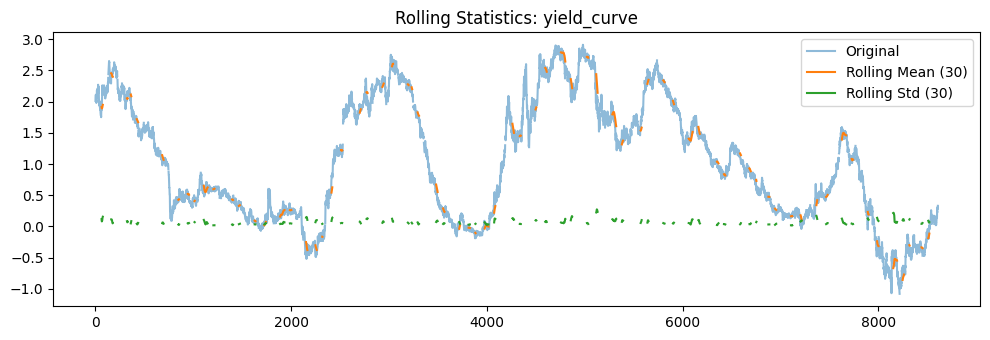

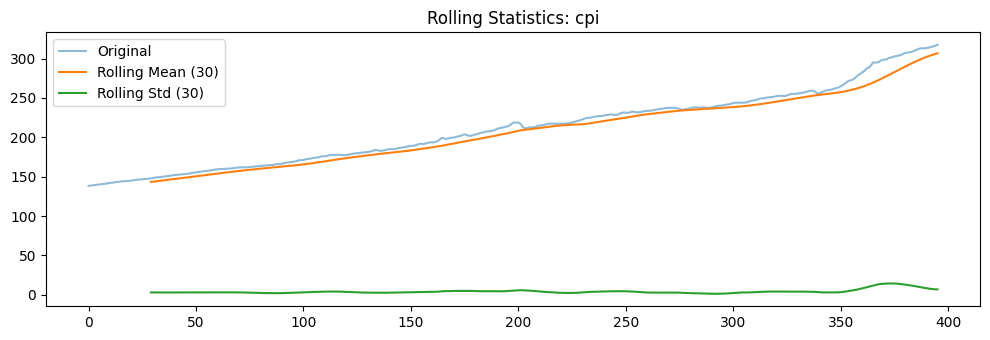

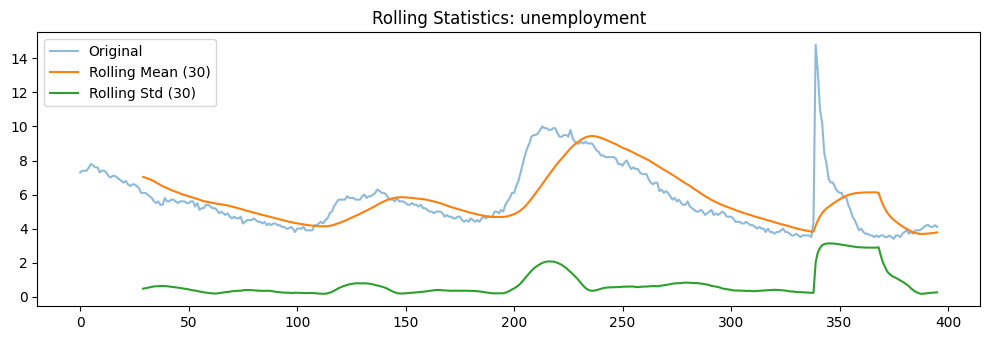

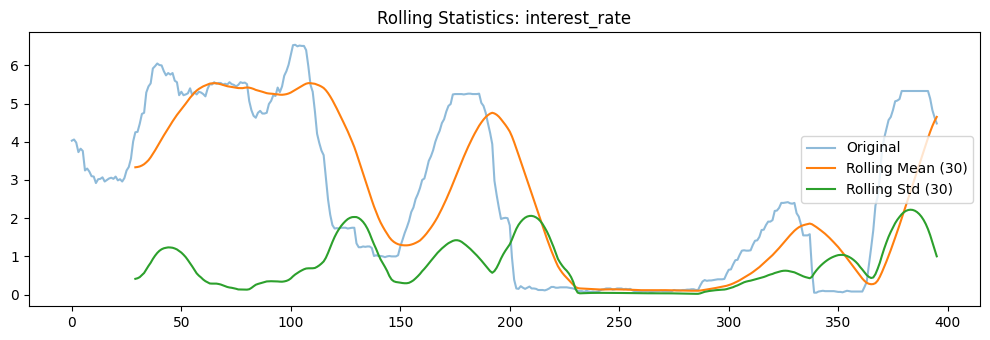

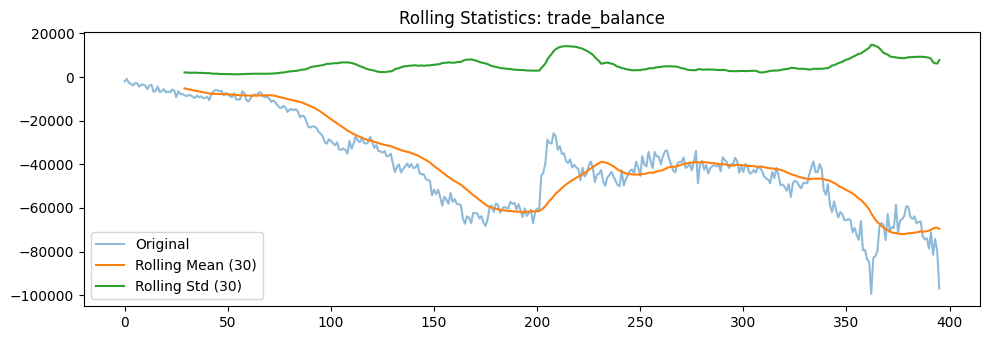

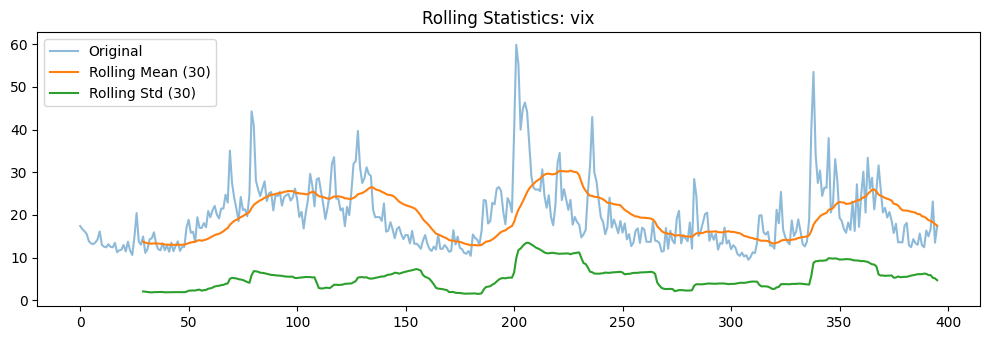

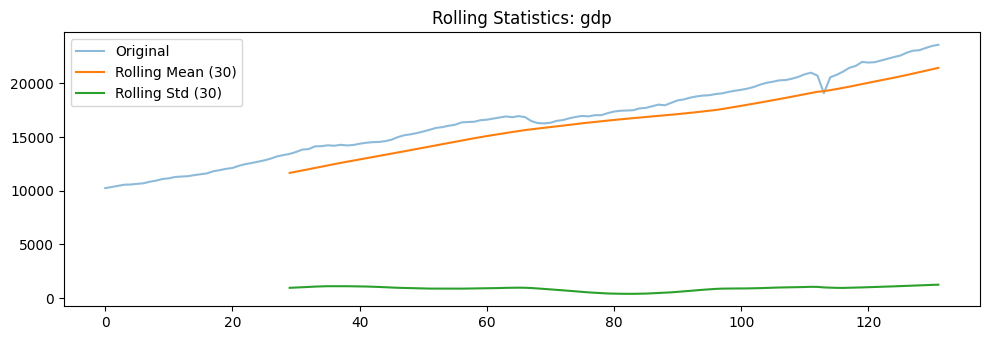

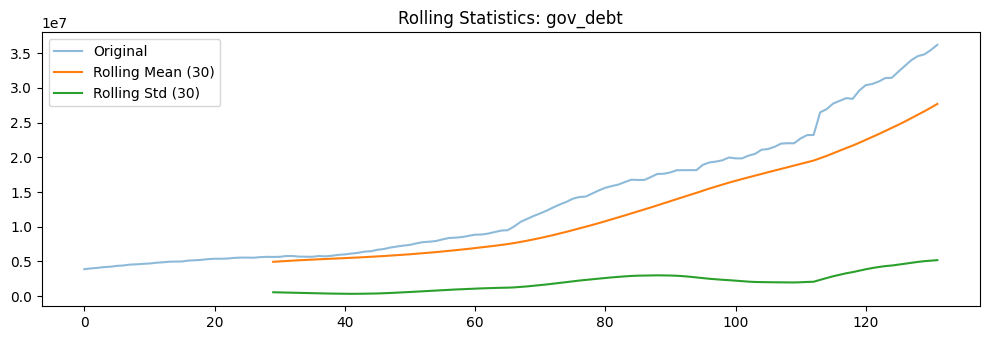

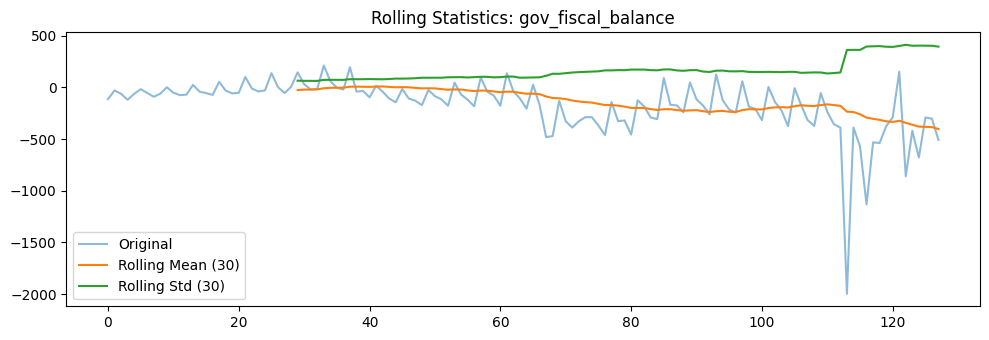

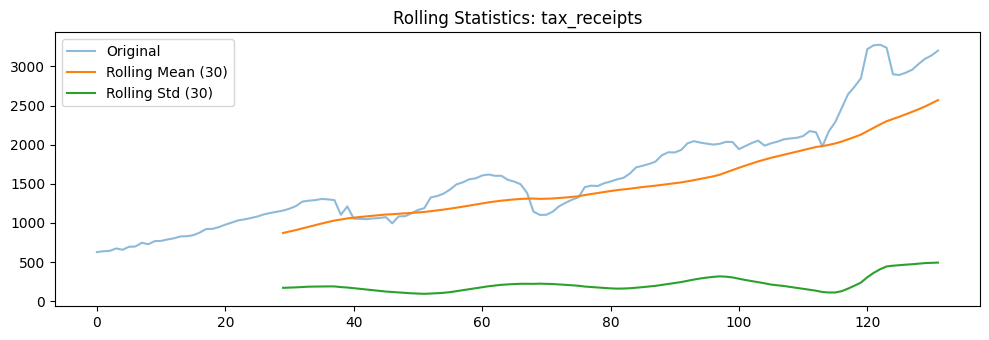

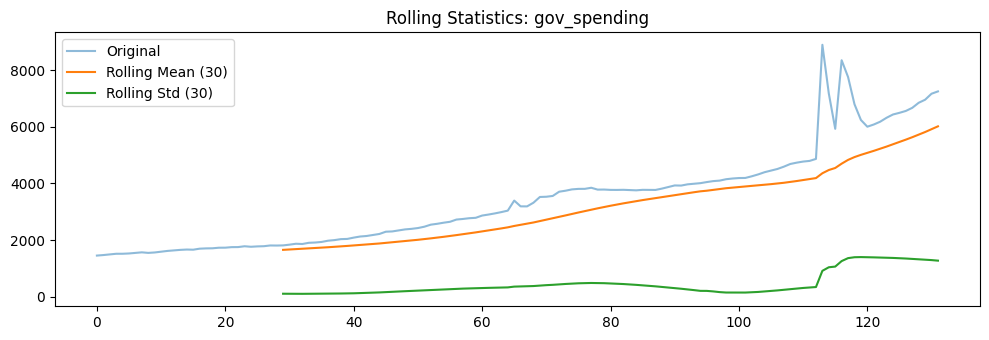

In [ ]:
# ===============================
# Rolling Statistics
# ===============================
# ---------- Rolling Stats Plotting Function ----------
def plot_rolling_stats(df: pd.DataFrame, series_cols: list = None, window: int = 30, title: str = None, save_path: str = None):
    if series_cols is None:
        series_cols = df.select_dtypes(include='number').columns.tolist()
    for col in series_cols:
        rolling_mean = df[col].rolling(window=window).mean()
        rolling_std = df[col].rolling(window=window).std()
        plt.figure(figsize=(10, 3.5))
        plt.plot(df.index, df[col], label="Original", alpha=0.5)
        plt.plot(df.index, rolling_mean, label=f"Rolling Mean ({window})")
        plt.plot(df.index, rolling_std, label=f"Rolling Std ({window})")
        plt.title(title or f"Rolling Statistics: {col}")
        plt.legend()
        plt.tight_layout()
        if save_path:
            dfname = df.name
            fname = f"{dfname}_{col}_rolling_stats.png"
            plt.savefig(os.path.join(save_path, fname))
        plt.show()

# ---------- Function Usage ----------
plot_rolling_stats(market_df, save_path=GRAPH_DIR)
plot_rolling_stats(target_df, save_path=GRAPH_DIR)
plot_rolling_stats(daily_macro_df, save_path=GRAPH_DIR)
plot_rolling_stats(monthly_macro_df, save_path=GRAPH_DIR)
plot_rolling_stats(quarterly_macro_df, save_path=GRAPH_DIR)

#### Notes on Rolling Stats
| Variable | Rolling Mean | Rolling STD | Interpretation |
| ---------------------- | ------------------------------------------- | ------------------------------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **VIX**                | Mean reverts around stable level (~20)      | Std spikes during crises but returns to baseline | Volatility index behaves as a **mean-reverting series** with **episodic bursts**. Suitable as a **regime indicator**; use raw or standardized values without differencing.   |
| **Unemployment**       | Slow cycles (expansions/contractions)       | Std fairly stable                                | Exhibits **cyclical, low-frequency oscillations** — stable variance implies stationarity after detrending. Capture cycles via long rolling windows or include ΔUnemployment. |
| **Trade Balance**      | Oscillating mean, not drifting              | Std moderately stable                            | Reflects **business cycle sensitivity** and mild stationarity. Differencing unnecessary; rolling normalization sufficient for conditioning.                                  |
| **Interest Rate**      | Mean tracks policy regimes                  | Std low but regime-dependent                     | **Regime-shifted trend series** (policy-driven). Use rate of change (ΔRate) for modeling responses; normalize or bucket by regime.                                           |
| **CPI**                | Upward drift in mean                        | Std increases proportionally                     | **Non-stationary inflation trend**; log-differencing (inflation rate) converts to stationary form. Useful for macro-conditioning rather than direct prediction.              |
| **Yield Curve**        | Mean fluctuates slowly with monetary cycles | Std mostly constant                              | **Smooth, cycle-dependent shape**; often stationary around zero after mean adjustment. Consider including slope/term spread as feature.                                      |
| **GDP**                | Strong upward drift                         | Std roughly proportional to mean                 | **Nominal scaling effect**; apply log transform and difference to remove exponential growth. Capture as slow-moving conditioning feature.                                    |
| **Tax Receipts**       | Drifting mean with GDP                      | Std scales with trend                            | **Highly correlated with GDP**, reflecting fiscal scale; log-difference or ratio-to-GDP can stabilize.                                                                       |
| **Gov Spending**       | Upward drift, policy-driven shifts          | Std roughly stable                               | **Policy step changes** (stimulus, austerity). Normalize and optionally smooth to align with macro cycles.                                                                   |
| **Gov Fiscal Balance** | Mean near zero                              | Std stable                                       | Roughly **stationary series** oscillating around equilibrium. May serve as a reliable macro condition variable without transformation.                                       |
| **Gov Debt**           | Clear rising trend, accelerating            | Std also rising                                  | **Non-stationary exponential growth**; log transform and difference recommended. Consider normalized ratio (Debt/GDP).                                                       |
| **Market Price**       | Strong upward drift in rolling mean         | Volatility bursts in 2020–2022                   | **Classic price process** with volatility clustering. Convert to log returns; include rolling volatility as regime feature.                                                  |
| **Market Volume**      | Same as S&P500 but more volatile            | Std increases in same periods                    | **Heteroscedastic growth process** reflecting trading activity surges. Log transform → difference; use rolling std as liquidity proxy.                                       |


### 2-3. Outlier Detection

In [ ]:
# ===============================
# Outlier Detection
# ===============================
# ---------- Ouliters Detection Function ----------
def detect_outliers(df: pd.DataFrame, series_cols: list = None, threshold: float = 3):
    if series_cols is None:
        series_cols = df.select_dtypes(include='number').columns.tolist()
    outliers = {}
    for col in series_cols:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers[col] = df[z_scores > threshold][col]
        if not outliers[col].empty:
            print(f"Outliers in {col}: {len(outliers[col])}")
            print(outliers[col])
    return outliers

# ---------- Function Usage ----------
#detect_outliers(market_df, save_path=GRAPH_DIR)
detect_outliers(target_df)
#detect_outliers(daily_macro_df)
#detect_outliers(monthly_macro_df)
#detect_outliers(quarterly_macro_df)

Outliers in open: 285
7519    139.190002
7520    137.699997
7521    154.009995
7522    143.929993
7523    142.960007
           ...    
8291    142.580002
8292    142.960007
8293    143.679993
8294    141.479996
8295    135.710007
Name: open, Length: 285, dtype: float64
Outliers in high: 284
7518    139.000000
7519    141.220001
7520    153.600006
7521    155.649994
7522    146.300003
           ...    
8290    142.820007
8291    143.449997
8292    144.119995
8293    143.949997
8294    142.789993
Name: high, Length: 284, dtype: float64
Outliers in low: 282
7519    134.419998
7520    137.699997
7521    143.889999
7522    138.520004
7523    140.839996
           ...    
8290    137.800003
8291    141.080002
8292    141.179993
8293    140.380005
8294    137.399994
Name: low, Length: 282, dtype: float64
Outliers in close: 286
7518    137.500000
7519    136.339996
7520    150.160004
7521    148.919998
7522    139.869995
           ...    
8290    142.059998
8291    141.979996
8292    143.99

{'open': 7519    139.190002
 7520    137.699997
 7521    154.009995
 7522    143.929993
 7523    142.960007
            ...    
 8291    142.580002
 8292    142.960007
 8293    143.679993
 8294    141.479996
 8295    135.710007
 Name: open, Length: 285, dtype: float64,
 'high': 7518    139.000000
 7519    141.220001
 7520    153.600006
 7521    155.649994
 7522    146.300003
            ...    
 8290    142.820007
 8291    143.449997
 8292    144.119995
 8293    143.949997
 8294    142.789993
 Name: high, Length: 284, dtype: float64,
 'low': 7519    134.419998
 7520    137.699997
 7521    143.889999
 7522    138.520004
 7523    140.839996
            ...    
 8290    137.800003
 8291    141.080002
 8292    141.179993
 8293    140.380005
 8294    137.399994
 Name: low, Length: 282, dtype: float64,
 'close': 7518    137.500000
 7519    136.339996
 7520    150.160004
 7521    148.919998
 7522    139.869995
            ...    
 8290    142.059998
 8291    141.979996
 8292    143.990005
 82

#### Notes on Outlier Detection
This was for completeness.

For financial time series, outliers have meanings by itself.

Therefore, no outlier handling will be carried on.

### 2-4. Correlation Analysis

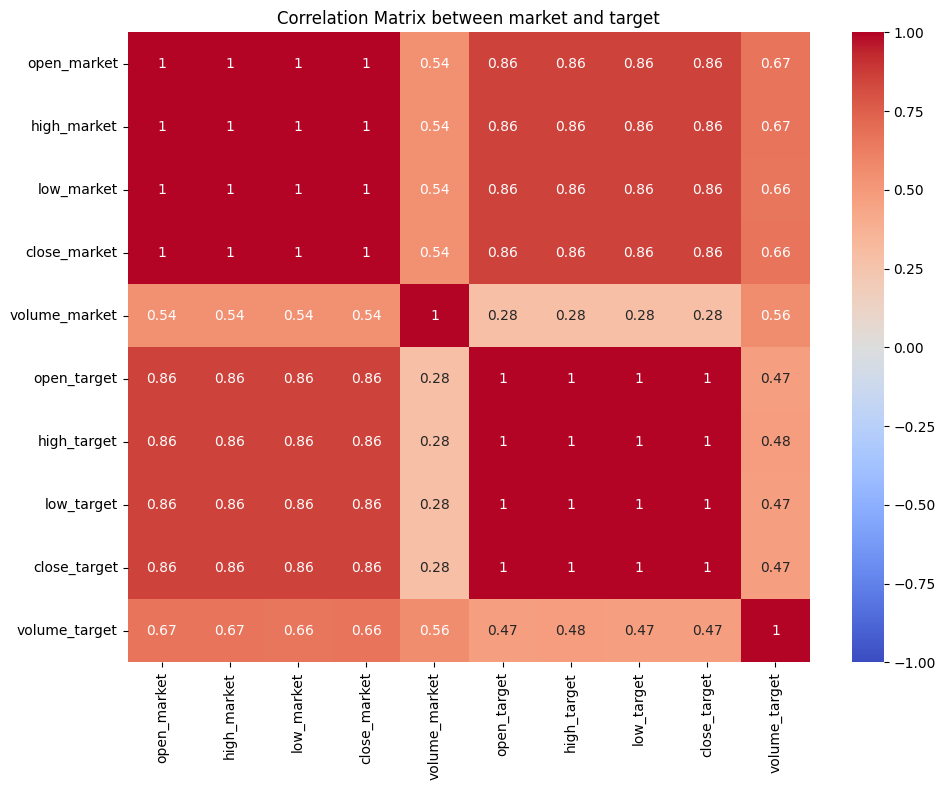

,open_market,high_market,low_market,close_market,volume_market,open_target,high_target,low_target,close_target,volume_target
open_market,1.000000,0.999953,0.999931,0.999879,0.542068,0.855538,0.855271,0.855959,0.855454,0.665251
high_market,0.999953,1.000000,0.999910,0.999935,0.543491,0.855618,0.855411,0.856063,0.855629,0.665932
low_market,0.999931,0.999910,1.000000,0.999944,0.539918,0.855429,0.855178,0.855962,0.855475,0.663868
close_market,0.999879,0.999935,0.999944,1.000000,0.541629,0.855474,0.855278,0.856015,0.855633,0.664766
volume_market,0.542068,0.543491,0.539918,0.541629,1.000000,0.284204,0.284493,0.283710,0.283964,0.556965
open_target,0.855538,0.855618,0.855429,0.855474,0.284204,1.000000,0.999762,0.999742,0.999437,0.473405
high_target,0.855271,0.855411,0.855178,0.855278,0.284493,0.999762,1.000000,0.999723,0.999751,0.477114
low_target,0.855959,0.856063,0.855962,0.856015,0.283710,0.999742,0.999723,1.000000,0.999776,0.470768
close_target,0.855454,0.855629,0.855475,0.855633,0.283964,0.999437,0.999751,0.999776,1.000000,0.474219
volume_target,0.665251,0.665932,0.663868,0.664766,0.556965,0.473405,0.477114,0.470768,0.474219,1.000000


In [ ]:
# ===============================
# Correlation Analysis
# ===============================
def plot_correlation_matrix(df: pd.DataFrame, series_cols: list = None, save_path: str = None):
    if series_cols is None:
        series_cols = df.select_dtypes(include='number').columns.tolist()
    corr = df[series_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    if save_path:
        dfname = df.name
        fname = f"{dfname}_correlation.png"
        plt.savefig(os.path.join(save_path, fname))
    plt.show()
    return corr

def plot_correlation_between_dfs(df1: pd.DataFrame, df2: pd.DataFrame, save_path: str = None):
    if 'Date' not in df1.columns or 'Date' not in df2.columns:
        raise ValueError("Both dataframes must have a 'Date' column for merging.")

    # Get numeric columns (excluding Date)
    series_cols_1 = df1.select_dtypes(include='number').columns.tolist()
    series_cols_2 = df2.select_dtypes(include='number').columns.tolist()

    # Merge on date
    merged_df = pd.merge(df1[['Date'] + series_cols_1], df2[['Date'] + series_cols_2],
                         on='Date', how='inner',
                         suffixes=(f'_{getattr(df1, "name", "df1")}', f'_{getattr(df2, "name", "df2")}'))

    # Compute correlation
    corr_matrix = merged_df.drop(columns=['Date']).corr()

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix between {getattr(df1, 'name', 'df1')} and {getattr(df2, 'name', 'df2')}")
    plt.tight_layout()

    # Optional save
    if save_path:
        fname = f"correlation_{getattr(df1, 'name', 'df1')}_and_{getattr(df2, 'name', 'df2')}.png"
        plt.savefig(os.path.join(save_path, fname))

    plt.show()
    return corr_matrix

# ---------- Function Usage ----------
#plot_correlation_matrix(market_df)           # Unecessary, but included for completeness
#plot_correlation_matrix(target_df)           # Unecessary, but included for completeness
#plot_correlation_matrix(daily_macro_df, save_path=GRAPH_DIR)
#plot_correlation_matrix(monthly_macro_df, save_path=GRAPH_DIR)
#plot_correlation_matrix(quarterly_macro_df, save_path=GRAPH_DIR)

plot_correlation_between_dfs(market_df, target_df, save_path=GRAPH_DIR)
#plot_correlation_between_dfs(quarterly_macro_df, monthly_macro_df, save_path=GRAPH_DIR)

#### Notes on Correlation
Correlation matrix of each column in each df is observed:

**market_df VS target_df**
- perfect correlation among open/high/low/close (for both market and target)
  - which is expected
  - need to check if there is no error, but if it is true, only one (close) is needed
  - otherwise, model will suffer from multicollinearity
  - for target data, need to check if data should be next-step shifted versions of market series

- Volume_market = moderately correlated (around 0.5)
  - adds useful dynamic info
  - should be kept as a seperate feature

- Market-Target Correlation = 0.86
  - indicates that current market levels strongly predict near-future target values (as expected)

**monthly_macro_df VS quarterly_macro_df**
- High multi-collinearity among growht/fiscal variables
  - gdp, gov_debt, tax_receipts, gov_spending, cpi are almost perfectly correlated
  - they likely reflect the same underlying economic gorwth trend
  - such redundancy can confuse models
  - consider make them into one feature

- fishcal balance has strong negative correlation (around -0.7) with gov_spending, gdp, cpi, etc
  - which make sense since high gov_spending or inflation worsens the fiscal balance
  - as the sign is opposite, this feature can add diversity if normalized properly

- Trade balance is anti-correlated with gdp growth (around -0.85)
  - during booms, imports rise faster than exports
  - suggests trade balance can act as a cyclical counter-indicator

- Unemployment & Interest rate are less correlated (-0.2 to -0.5) with with gov_spending, gdp, cpi, etc
  - these indexes can bring independent info
  - useful for temporal prediction when other variables are collinear

- VIX has near-zero correlations with others
  - market volatility index seems largely independent of macro variables here
  - likely due to different time frequencies
  - or this index might be more related with volume data of target and market

### 2-5. Seasonality & Autocorrelation

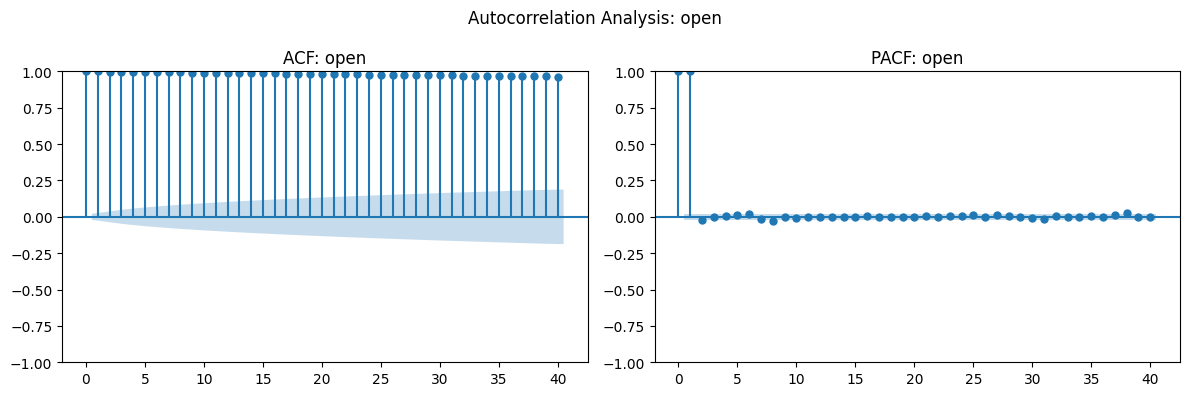

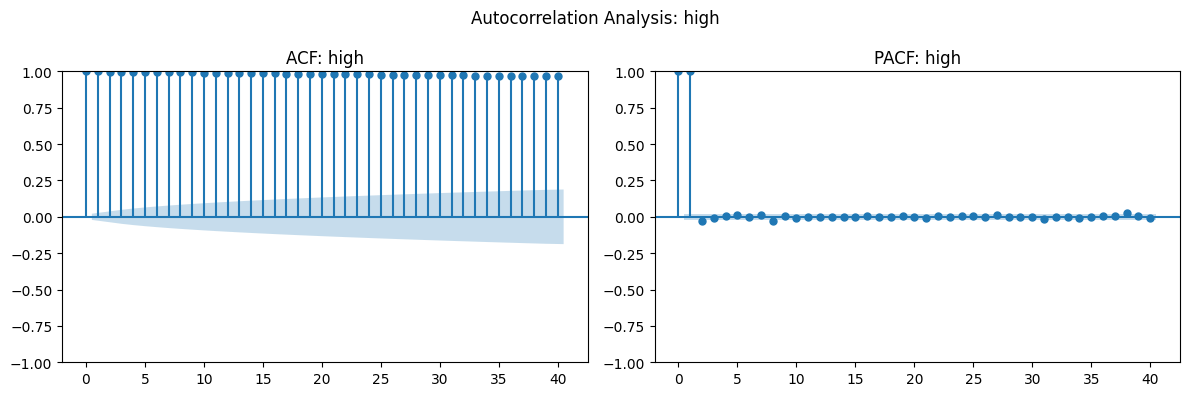

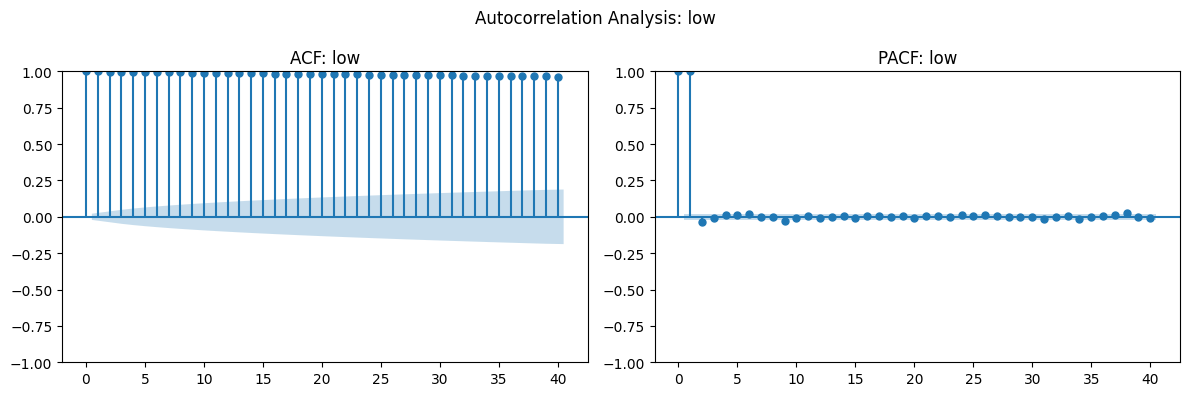

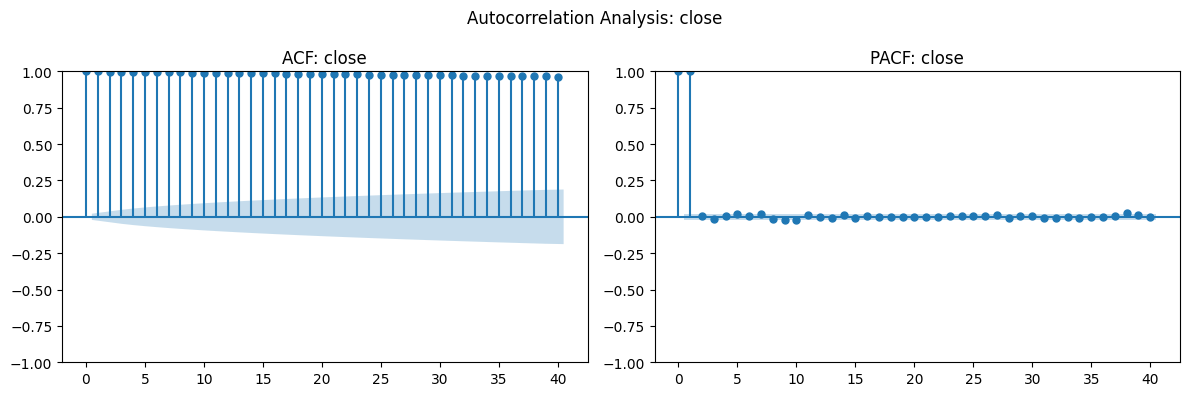

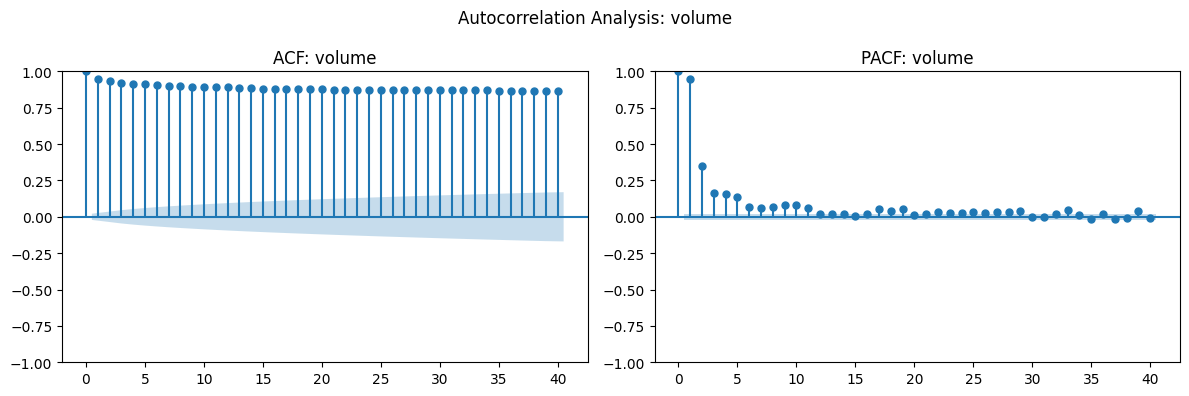

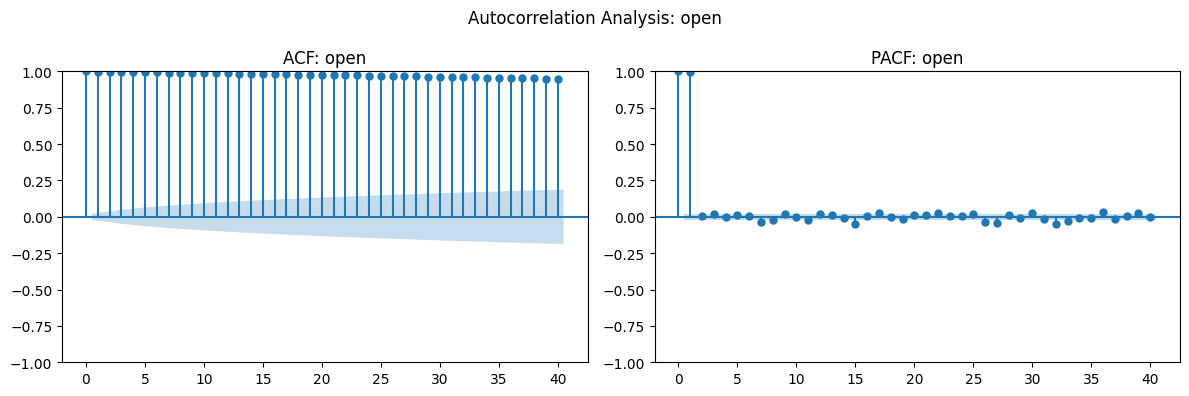

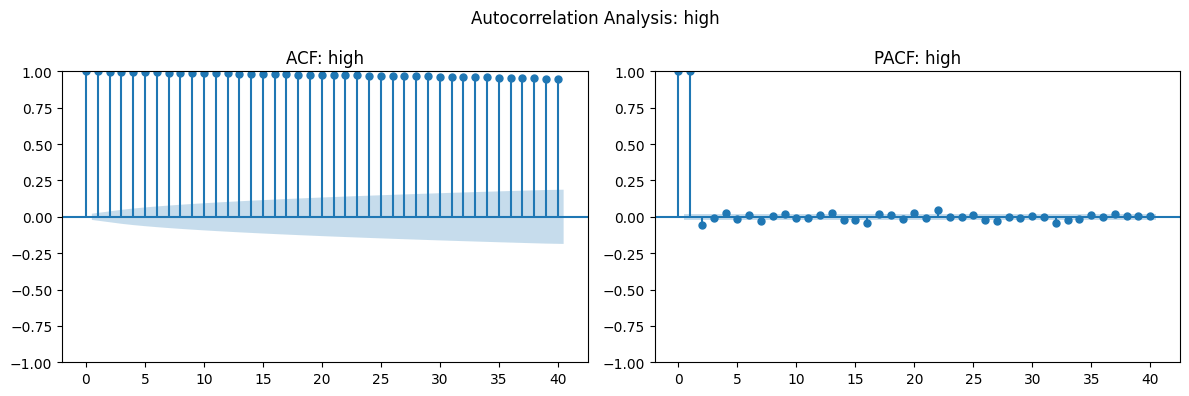

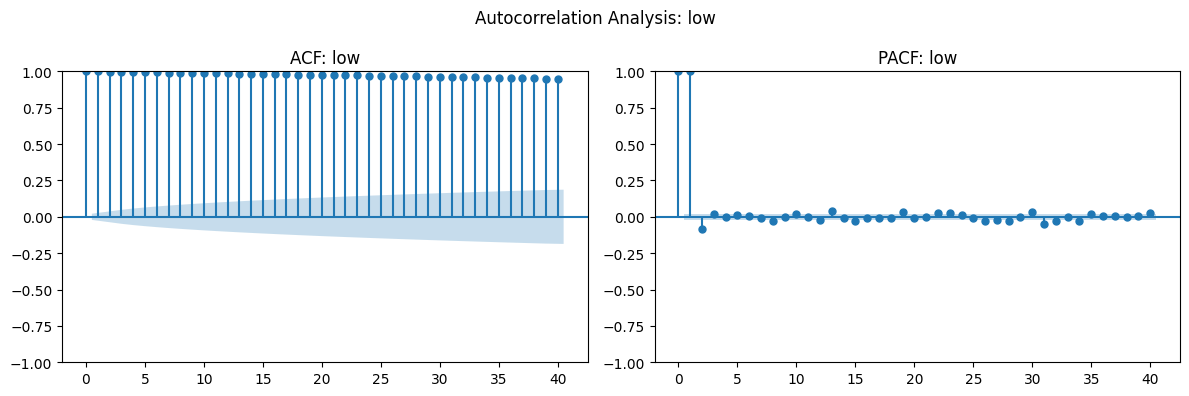

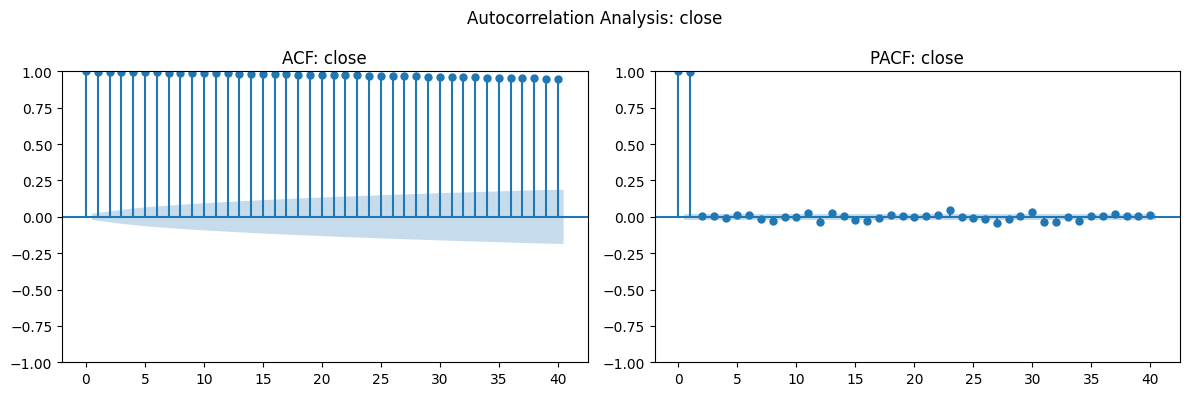

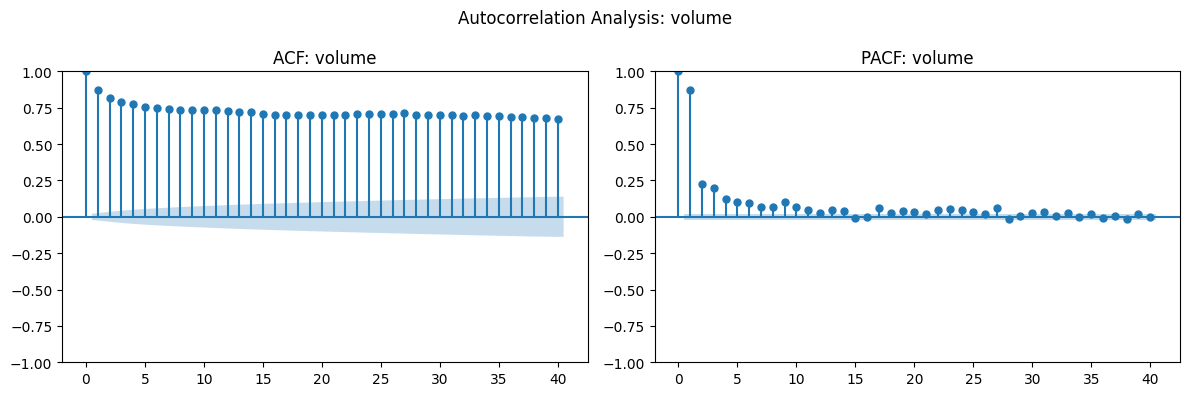

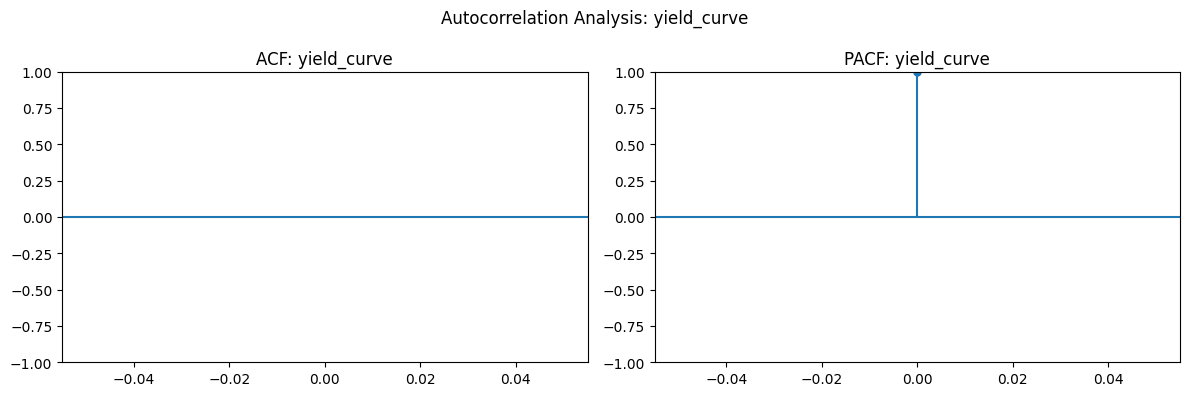

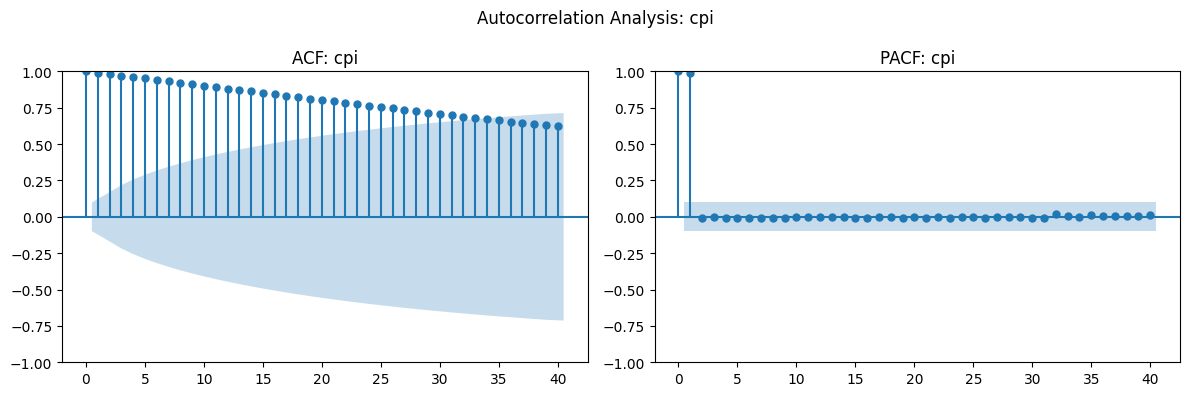

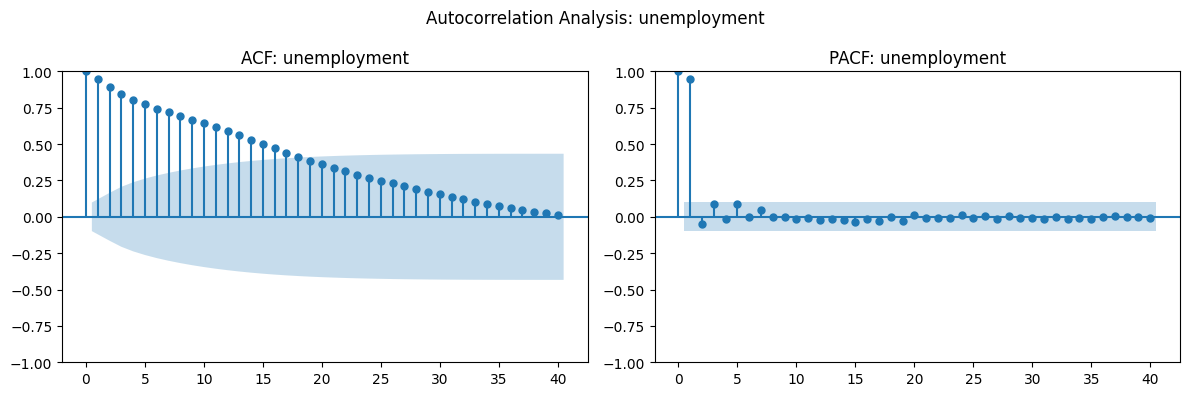

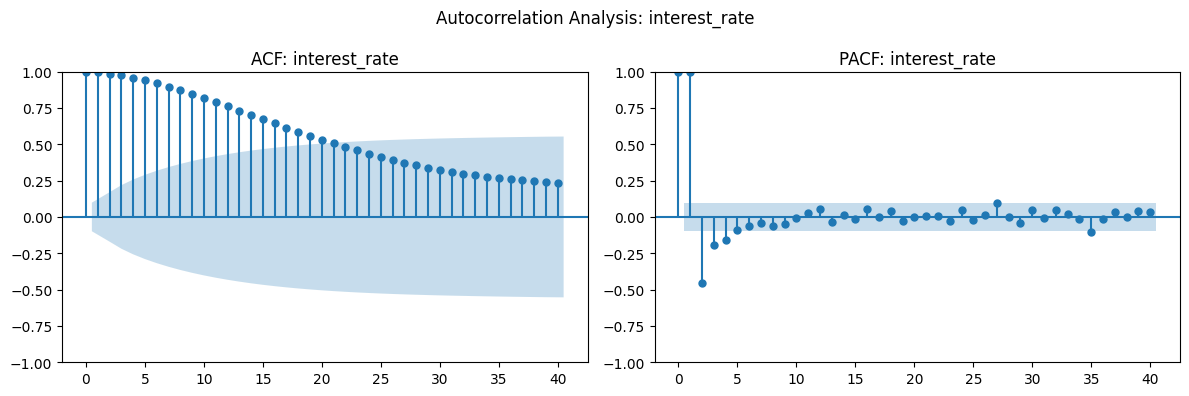

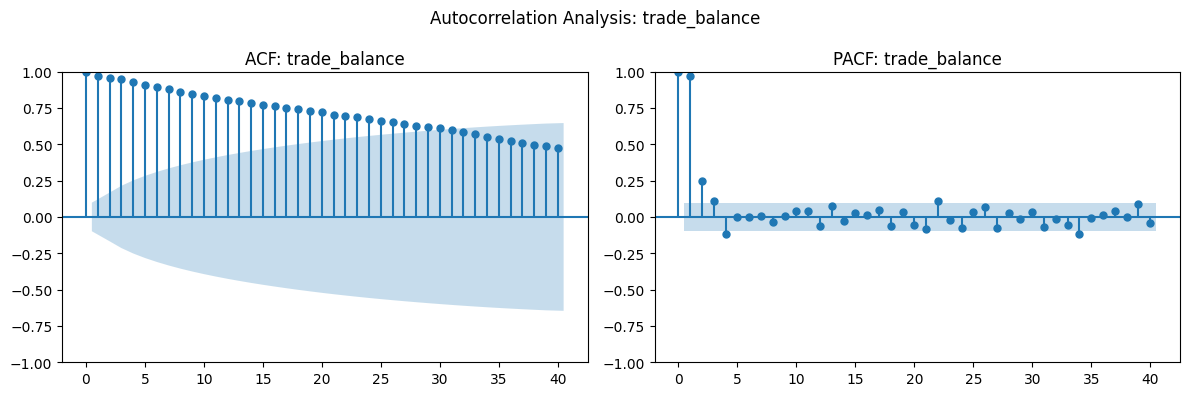

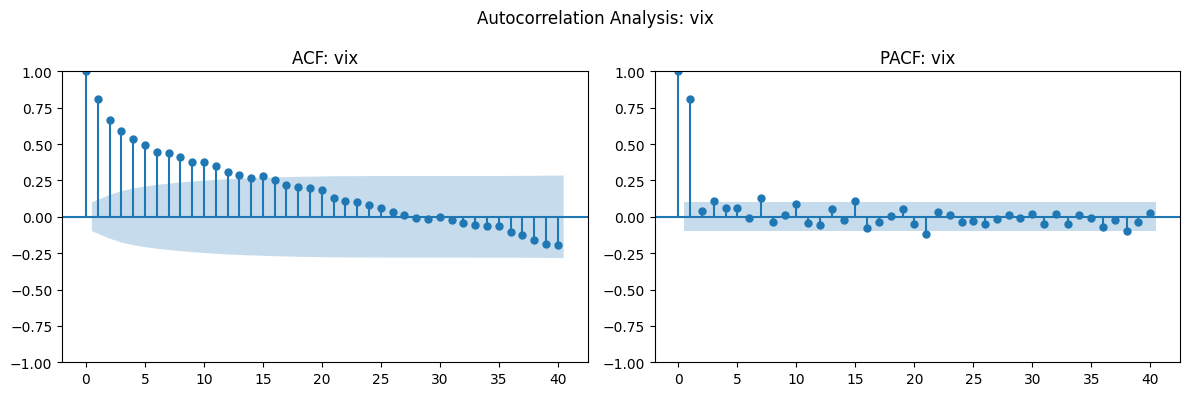

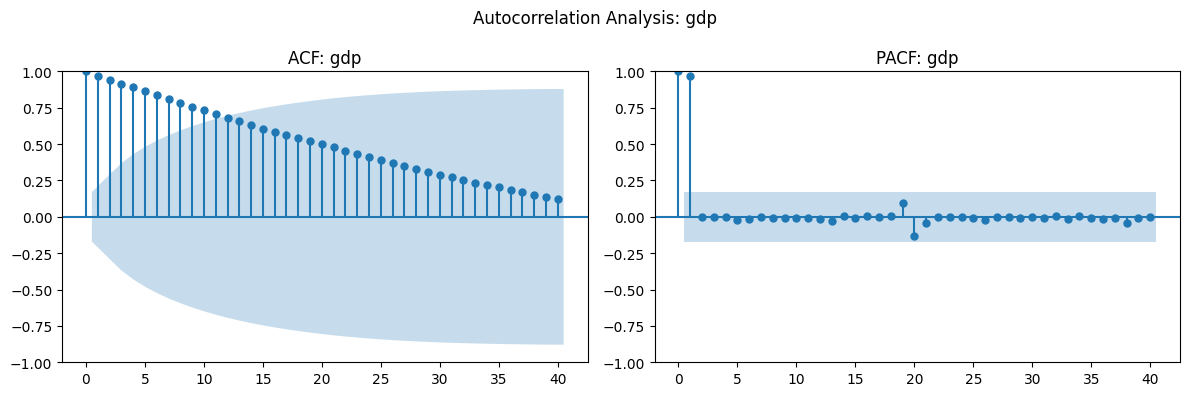

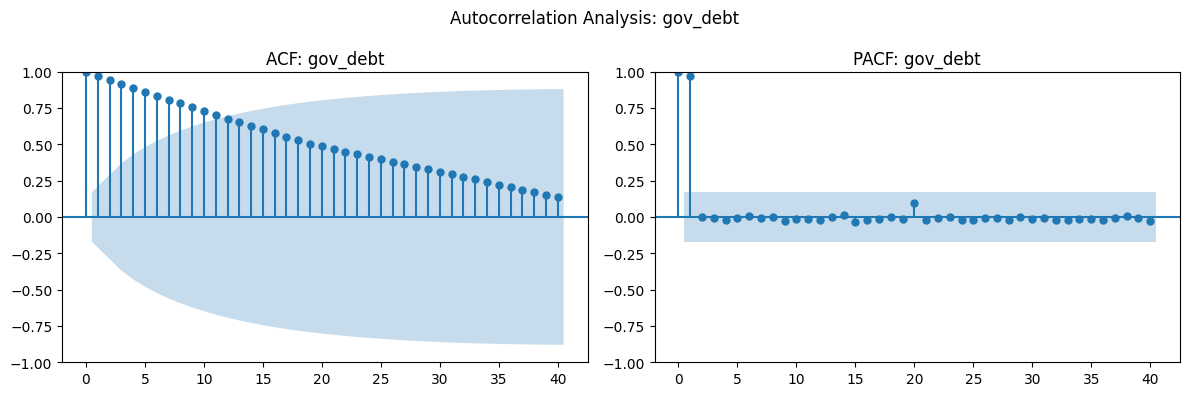

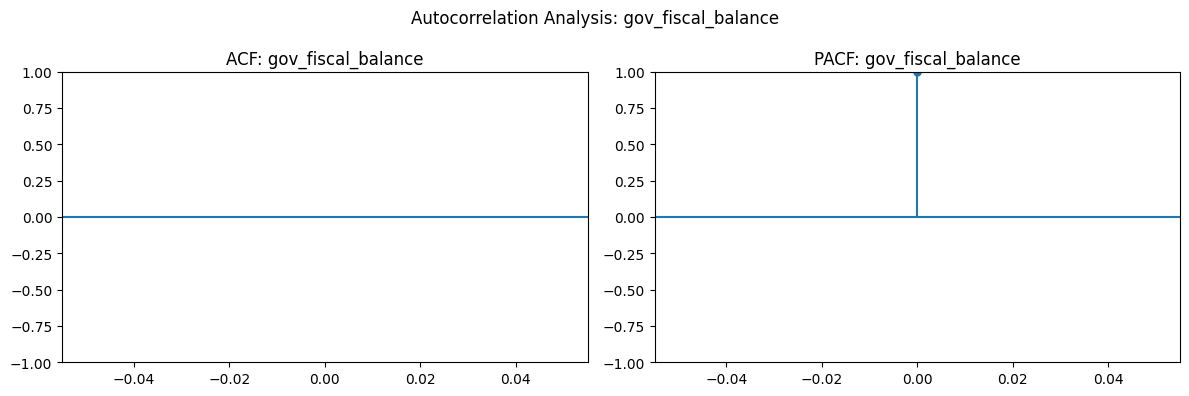

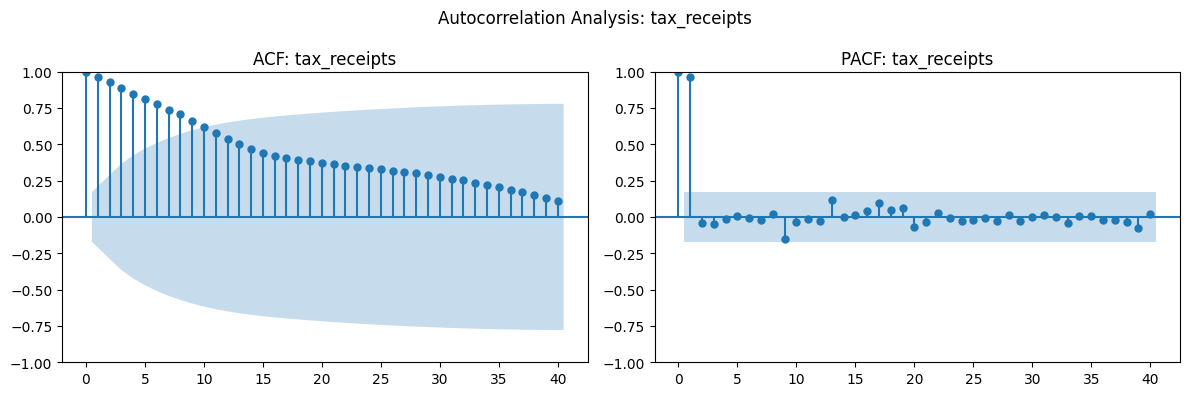

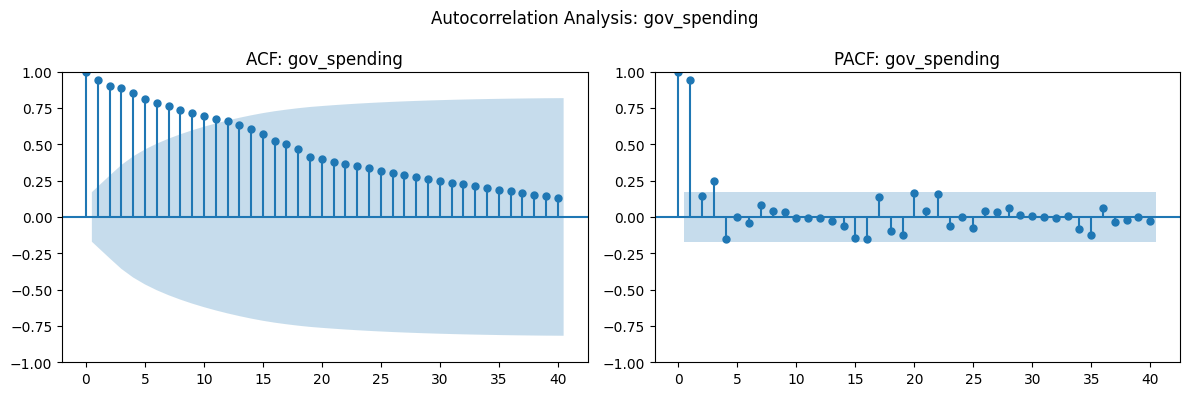

In [ ]:
# ===============================
# Seasonality and Autocorrelation
# ===============================
# ---------- ACF/PACF Running and Plotting Function ----------
def plot_acf_pacf(df: pd.DataFrame, series_cols: list = None, lags: int = 40, title: str = None, save_path: str = None):
    if series_cols is None:
        series_cols = df.select_dtypes(include='number').columns.tolist()
    for col in series_cols:
        plt.figure(figsize=(12, 4))
        plt.subplot(121)
        plot_acf(df[col], lags=lags, ax=plt.gca(), title=f"ACF: {col}")
        plt.subplot(122)
        plot_pacf(df[col], lags=lags, ax=plt.gca(), title=f"PACF: {col}")
        plt.suptitle(title or f"Autocorrelation Analysis: {col}")
        plt.tight_layout()
        if save_path:
            dfname = df.name
            fname = f"{dfname}_{col}_acf_pacf.png"
            plt.savefig(os.path.join(save_path, fname))
        plt.show()

# ---------- Function Usage ----------
plot_acf_pacf(market_df, save_path=GRAPH_DIR)
plot_acf_pacf(target_df, save_path=GRAPH_DIR)
plot_acf_pacf(daily_macro_df, save_path=GRAPH_DIR)
plot_acf_pacf(monthly_macro_df, save_path=GRAPH_DIR)
plot_acf_pacf(quarterly_macro_df, save_path=GRAPH_DIR)

#### Notes on ACF and PACF

| Variable | ACF Pattern | PACF Pattern | Interpretation |
|-----------|--------------|---------------|------------------------------|
| **VIX** | Slow exponential decay; long positive autocorrelation (~20–30 lags) | Strong lag-1, then negligible | Stationary AR(1)-like process (no seasonality), High persistence (near-AR(1)), non-stationary in level |
| **Unemployment** | Very strong persistence (ACF > 0.8 for >30 lags) | Single dominant lag-1 spike | Non-stationary with persistent trend; potential low-frequency cycle (~12–18 months) |
| **Trade Balance** | Persistent positive autocorrelation, slow decay | Lag-1 strong, minor at 2–3 | Clear seasonality, possibly yearly, meaning it is Trend-dominated series (possible structural drift) |
| **Interest Rate** | Slow decay (ACF > 0.5 for ~25 lags) | Lag-1 dominant, slight negative at lag-2 | Classic AR(1)/AR(2) process; difference-stationary, persistent memory but not cyclic |
| **CPI** | Moderate persistence, mild seasonal bumps | small but non-zero up to lag 3–4 | Mild trend + weak seasonality |
| **Yield Curve** | Short memory; Persistent ACF, mild periodic behavior | cuts off quickly; Lag-1 dominant, small lag-3 signal | Semi-stationary with cyclical components |
| **GDP** | Extremely slow ACF decay | PACF cuts off at lag-1 | Long memory, non-stationary |
| **Tax Receipts** | Persistent with mild seasonal shape | Lag-1 dominant, small lag-4/lag-12 | Structural + seasonal component |
| **Gov Spending** | Same as tax: slow decay, small cyclical oscillations | Lag-1, small lag-4 | Trend-dominated, non-stationary |
| **Gov Fiscal Balance** | Positive ACF up to 15+ lags | PACF small across all | Weak negative autocorrelation at lag 1 with long drift → stationary but noisy |
| **Gov Debt** | Persistent (ACF ≈ 1.0), no cutoff | PACF lag-1 spike only | Integrated process, Near unit root — trend exists |
| **Market** | Decays slowly, often indicating long memory/momentum | sharp cutoff after lag 1 --> AR(1)-like behavior |  Financial returns are weakly autocorrelated; prices themselves are non-stationary |

### 2-6. Stationary Checks (ADF Test)

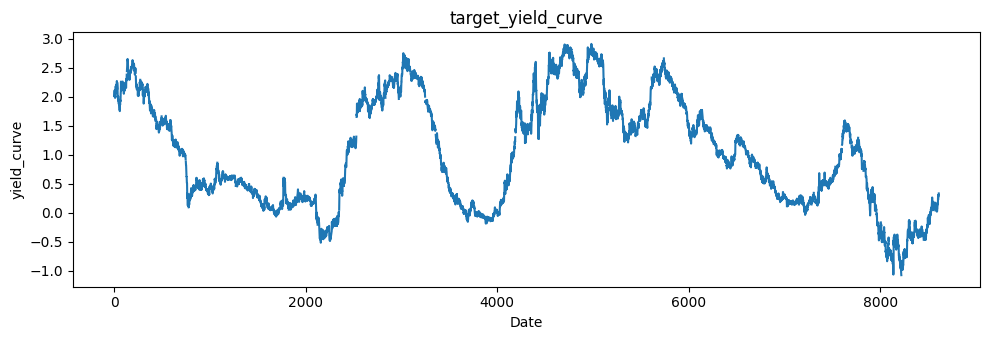

In [ ]:
# ===================================
# General Visualization of Dataframe
# ===================================
# ---------- Single Series Plotting Function ----------
def plot_series(series: pd.Series, title: str = None, save_path: str = None, show: bool = True):
    """Plot a single time series using matplotlib (one plot per call)."""
    plt.figure(figsize=(10, 3.5))
    plt.plot(series.index, series.values)
    plt.xlabel("Date")
    plt.ylabel(series.name if series.name else "value")
    plt.title(title or f"Time series: {series.name}")
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

# ---------- Visualization Function ----------
def visualization(df: pd.DataFrame, series_cols: list = None, prefix: str = "", save_plots: str = None):
    """For each column in series_cols (or all numeric columns if None),
       plot a line chart.
    """
    if series_cols is None:
        # pick numeric columns only
        series_cols = df.select_dtypes(include='number').columns.tolist()
    results = []
    for col in series_cols:
        sr = df[col].copy()
        sr.name = col
        # plot
        title = f"{prefix}{col}"
        save_path = None
        if save_plots:
            save_path = os.path.join(save_plots, f"{prefix}{col}.png")
        plot_series(sr, title=title, save_path=save_path, show=True)

# ---------- Function Usage ----------
#visualization(market_df, series_cols=['close'], prefix='market_')
#visualization(target_df, series_cols=['close'], prefix='target_')
visualization(daily_macro_df, prefix='target_')

=== ADF test for cpi (level) ===
  ADF stat  = 1.4846
  p-value   = 9.9747e-01
    critical (1%) = -3.4477
    critical (5%) = -2.8692
    critical (10%) = -2.5708
  Verdict: Non-stationary (fail to reject H0)


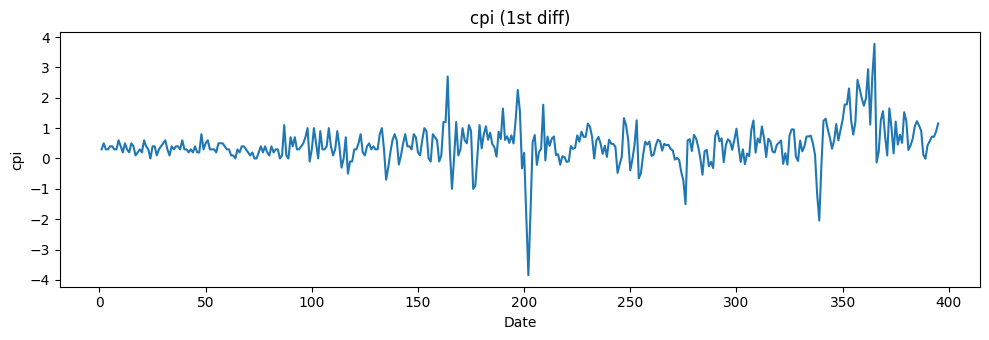

=== ADF test for cpi (1st diff) ===
  ADF stat  = -3.0463
  p-value   = 3.0794e-02
  Verdict: Stationary (reject H0)
=== ADF test for unemployment (level) ===
  ADF stat  = -3.0054
  p-value   = 3.4390e-02
    critical (1%) = -3.4471
    critical (5%) = -2.8689
    critical (10%) = -2.5707
  Verdict: Stationary (reject H0)
=== ADF test for interest_rate (level) ===
  ADF stat  = -2.9270
  p-value   = 4.2302e-02
    critical (1%) = -3.4473
    critical (5%) = -2.8690
    critical (10%) = -2.5707
  Verdict: Stationary (reject H0)
=== ADF test for trade_balance (level) ===
  ADF stat  = -0.6659
  p-value   = 8.5539e-01
    critical (1%) = -3.4475
    critical (5%) = -2.8691
    critical (10%) = -2.5708
  Verdict: Non-stationary (fail to reject H0)


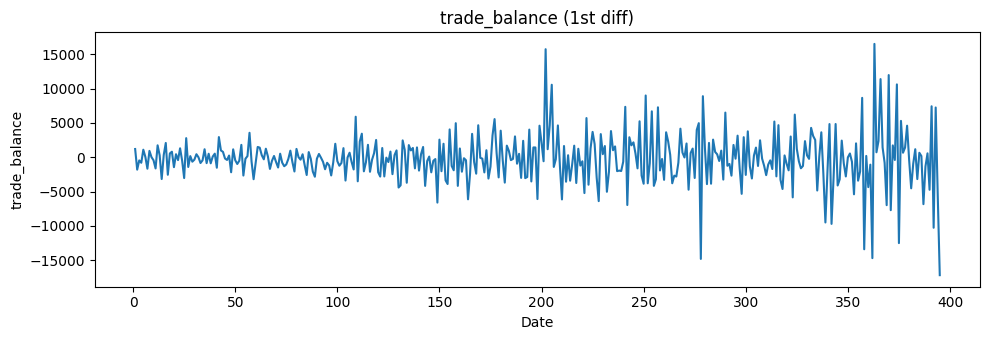

=== ADF test for trade_balance (1st diff) ===
  ADF stat  = -5.5361
  p-value   = 1.7437e-06
  Verdict: Stationary (reject H0)
=== ADF test for vix (level) ===
  ADF stat  = -3.5617
  p-value   = 6.5361e-03
    critical (1%) = -3.4473
    critical (5%) = -2.8690
    critical (10%) = -2.5707
  Verdict: Stationary (reject H0)

=== Summary ===


,level_adf_stat,level_p_value,level_is_stationary,n_obs,diff_adf_stat,diff_p_value,diff_is_stationary
series,,,,,,,
cpi,1.484563,0.997466,False,380,-3.046261,0.030794,True
unemployment,-3.005433,0.034390,True,393,NaN,NaN,NaN
interest_rate,-2.926956,0.042302,True,389,NaN,NaN,NaN
trade_balance,-0.665897,0.855386,False,383,-5.536058,0.000002,True
vix,-3.561737,0.006536,True,389,NaN,NaN,NaN


=== ADF test for gdp (level) ===
  ADF stat  = 0.4200
  p-value   = 9.8223e-01
    critical (1%) = -3.4817
    critical (5%) = -2.8840
    critical (10%) = -2.5788
  Verdict: Non-stationary (fail to reject H0)


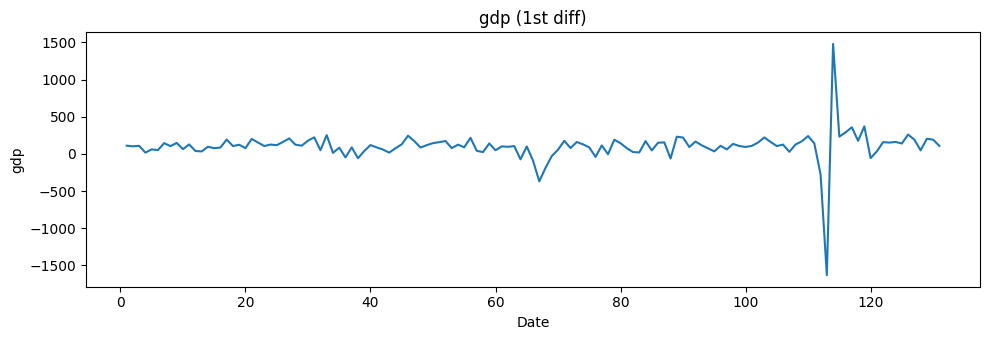

=== ADF test for gdp (1st diff) ===
  ADF stat  = -13.6987
  p-value   = 1.3018e-25
  Verdict: Stationary (reject H0)
=== ADF test for gov_debt (level) ===
  ADF stat  = 6.0769
  p-value   = 1.0000e+00
    critical (1%) = -3.4813
    critical (5%) = -2.8839
    critical (10%) = -2.5787
  Verdict: Non-stationary (fail to reject H0)


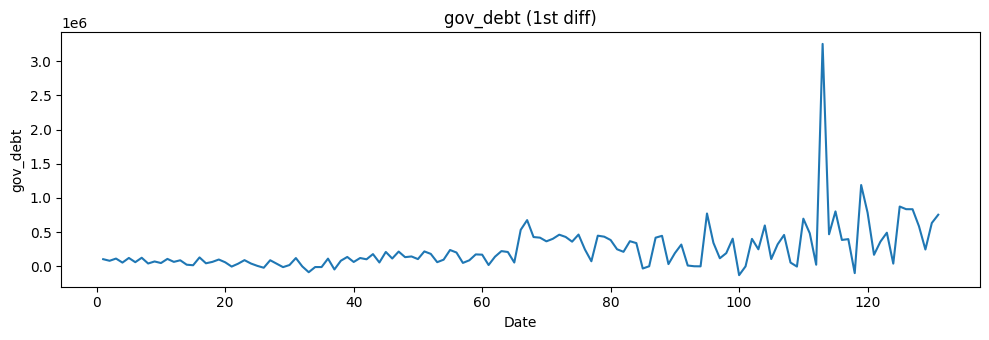

=== ADF test for gov_debt (1st diff) ===
  ADF stat  = -1.4683
  p-value   = 5.4914e-01
  Verdict: Non-stationary (fail to reject H0)
=== ADF test for gov_fiscal_balance (level) ===
  ADF stat  = -2.1192
  p-value   = 2.3688e-01
    critical (1%) = -3.4842
    critical (5%) = -2.8851
    critical (10%) = -2.5794
  Verdict: Non-stationary (fail to reject H0)


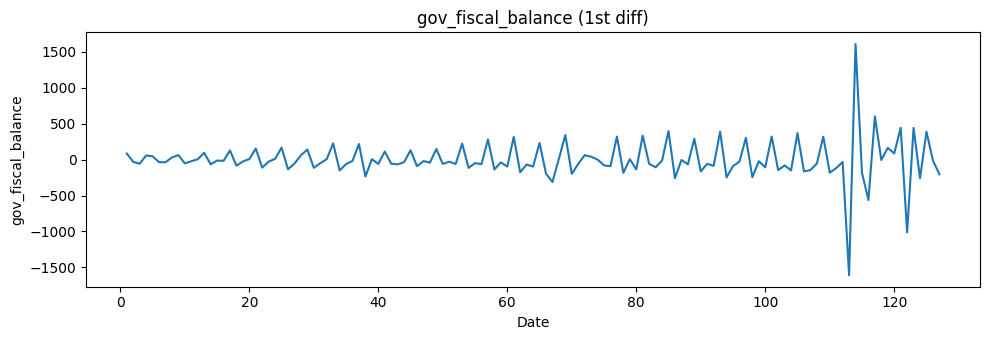

=== ADF test for gov_fiscal_balance (1st diff) ===
  ADF stat  = -6.0760
  p-value   = 1.1211e-07
  Verdict: Stationary (reject H0)
=== ADF test for tax_receipts (level) ===
  ADF stat  = 0.8050
  p-value   = 9.9172e-01
    critical (1%) = -3.4842
    critical (5%) = -2.8851
    critical (10%) = -2.5794
  Verdict: Non-stationary (fail to reject H0)


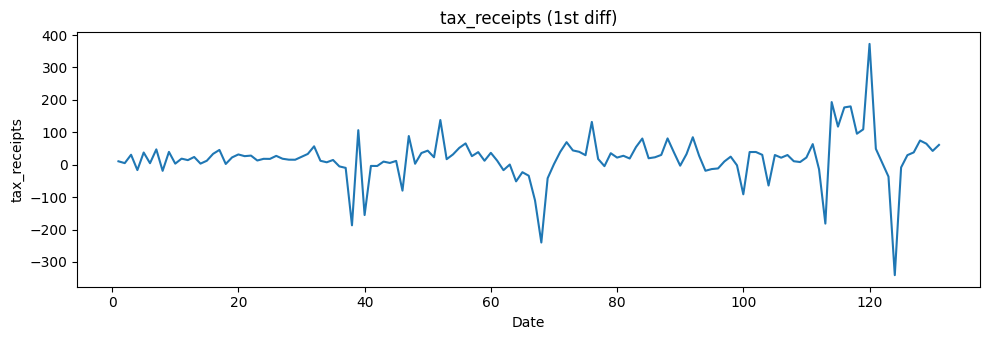

=== ADF test for tax_receipts (1st diff) ===
  ADF stat  = -5.0578
  p-value   = 1.7033e-05
  Verdict: Stationary (reject H0)
=== ADF test for gov_spending (level) ===
  ADF stat  = 0.9157
  p-value   = 9.9329e-01
    critical (1%) = -3.4847
    critical (5%) = -2.8853
    critical (10%) = -2.5795
  Verdict: Non-stationary (fail to reject H0)


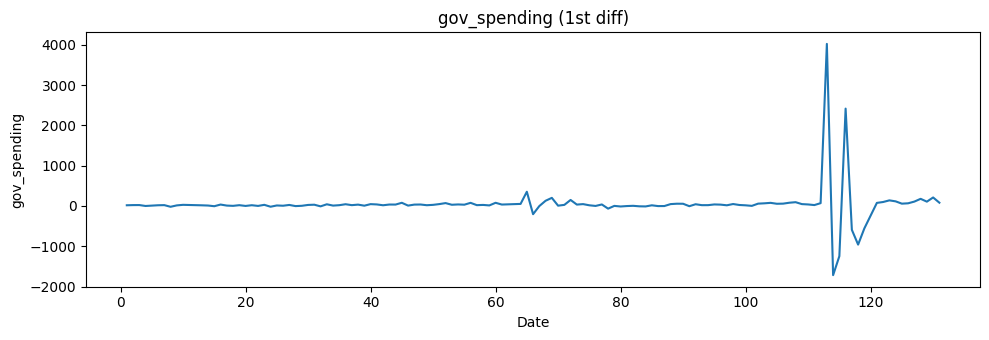

=== ADF test for gov_spending (1st diff) ===
  ADF stat  = -5.8934
  p-value   = 2.8893e-07
  Verdict: Stationary (reject H0)

=== Summary ===


,level_adf_stat,level_p_value,level_is_stationary,n_obs,diff_adf_stat,diff_p_value,diff_is_stationary
series,,,,,,,
gdp,0.420006,0.982228,False,130,-13.698744,1.301810e-25,True
gov_debt,6.076907,1.000000,False,131,-1.468287,5.491370e-01,False
gov_fiscal_balance,-2.119173,0.236875,False,124,-6.076024,1.121094e-07,True
tax_receipts,0.805021,0.991717,False,124,-5.057806,1.703263e-05,True
gov_spending,0.915693,0.993292,False,123,-5.893373,2.889258e-07,True


In [ ]:
# =============
# ADF Testing
# =============
# ---------- Helper Function ----------
def adf_test(series: pd.Series, autolag: str = "AIC", signif_level: float = 0.05):
    """Run Augmented Dickey-Fuller test and return a dict with results and a verdict.
       The null hypothesis: series has a unit root (non-stationary).
       If p-value < signif_level → reject null → series is stationary.
    """
    s = series.dropna()
    if len(s) < 10:
        return {"ok": False, "reason": "too short", "n": len(s)}
    res = adfuller(s, autolag=autolag)
    output = {
        "adf_stat": res[0],
        "p_value": res[1],
        "used_lag": res[2],
        "n_obs": res[3],
        "critical_values": res[4],
        "icbest": res[5] if len(res) > 5 else None
    }
    output["is_stationary"] = output["p_value"] < signif_level
    output["verdict"] = ("Stationary (reject H0)" if output["is_stationary"]
                         else "Non-stationary (fail to reject H0)")
    return output

# ---------- ADF Test Execution Function ----------
def run_ADF(df: pd.DataFrame, series_cols: list = None, prefix: str = "", test_diff: bool = False):
    """For each column in series_cols (or all numeric columns if None),
       run ADF test and return a DataFrame summarising results.
    """
    if series_cols is None:
        # pick numeric columns only
        series_cols = df.select_dtypes(include='number').columns.tolist()
    results = []
    for col in series_cols:
      sr = df[col].copy()
      title = f"{prefix}{col}"
      sr.name = col
      # ADF on level
      adf_res = adf_test(sr)
      print(f"=== ADF test for {title} (level) ===")
      if not adf_res.get("ok", True):
          print("  Skipped ADF:", adf_res.get("reason"))
      else:
          print(f"  ADF stat  = {adf_res['adf_stat']:.4f}")
          print(f"  p-value   = {adf_res['p_value']:.4e}")
          for k, v in adf_res["critical_values"].items():
              print(f"    critical ({k}) = {v:.4f}")
          print("  Verdict:", adf_res["verdict"])
      row = {
          "series": title,
          "level_adf_stat": adf_res.get("adf_stat"),
          "level_p_value": adf_res.get("p_value"),
          "level_is_stationary": adf_res.get("is_stationary", False),
          "n_obs": adf_res.get("n_obs")
      }
      # Test first difference if non-stationary and requested
      if test_diff and adf_res.get("ok", True) and not adf_res["is_stationary"]:
          diff = sr.diff().dropna()
          plot_series(diff, title=f"{title} (1st diff)", save_path=None, show=True)
          adf_diff = adf_test(diff)
          print(f"=== ADF test for {title} (1st diff) ===")
          print(f"  ADF stat  = {adf_diff.get('adf_stat',float('nan')):.4f}")
          print(f"  p-value   = {adf_diff.get('p_value',float('nan')):.4e}")
          print("  Verdict:", adf_diff.get("verdict"))
          row.update({
              "diff_adf_stat": adf_diff.get("adf_stat"),
              "diff_p_value": adf_diff.get("p_value"),
              "diff_is_stationary": adf_diff.get("is_stationary", False)
          })
      results.append(row)
    # summary DF
    res_df = pd.DataFrame(results).set_index("series")
    return res_df

# ---------- Function Usage ----------
#adf_res = run_ADF(market_df, series_cols=['close'], test_diff=True)
#print("\n=== Summary ===")
#display(adf_res)

#adf_res = run_ADF(market_df, series_cols=['close'], test_diff=True)
#print("\n=== Summary ===")
#display(adf_res)

#adf_res = run_ADF(daily_macro_df, test_diff=True)
#print("\n=== Summary ===")
#display(adf_res)

adf_res = run_ADF(monthly_macro_df, test_diff=True)
print("\n=== Summary ===")
display(adf_res)


adf_res = run_ADF(quarterly_macro_df, test_diff=True)
print("\n=== Summary ===")
display(adf_res)

#### Notes on Stationary Checks

| Variable | ADF Summary | Stationarity Status | Notes |
|-----------|--------------|---------|------------------------------|
| **VIX** | ADF stationary in levels | Stationary | Stationary but heteroskedastic; optional smoothing (EMA)l |
| **Unemployment** |ADF non-stationary, diff stationary | I(1) | Often trend + cycle; differencing removes drift |
| **Trade Balance** | ADF near threshold; diff stable | I(1) or Borderline | Check residual seasonality |
| **Interest Rate** |ADF non-stationary, diff stationary | I(1) | Typical persistent macro series |
| **CPI** | ADF non-stationary, diff stationary | I(1) | Use inflation rate instead of CPI level |
| **Yield Curve** | ADF non-stationary, diff stationary | I(1) | Long-memory structure; use changes not levels |
| **GDP** | ADF non-stationary, diff stationary | I(1) | Log-diff = % growth; preserves interpretability |
| **Tax Receipts** | ADF non-stationary, diff stationary | I(1) | Positive-only → log-scale safe |
| **Gov Spending** | ADF non-stationary, diff stationary | I(1) | Avoid raw values—trend dominates |
| **Gov Fiscal Balance** | ADF non-stationary, diff stationary | I(1) | Already mean-reverting; no transformation needed |
| **Gov Debt** | ADF non-stationary, diff stationary | I(1) | Use log if debt > 0 always |
| **Market Close** | ADF non-stationary, diff stationary | I(1) |  Random walk with drift; log-return removes unit root |
| **Market Volume** | ADF fails at level, passes after diff | I(1) | Volume often multiplicative; log-diff stabilizes variance. |

#### Background Knowledge about Stationary Checks
**What is Stationary**
-stationary time series is one whose statistical properties—such as its mean, variance, and autocovariance—do not change over time. This means the series has no trend, no seasonality, and a constant level of variability, making it easier to model and predict because its underlying patterns remain stable.  
Key characteristics of stationary time series
Constant mean: The average value of the series does not systematically increase or decrease over time.
Constant variance: The spread or volatility of the series remains consistent.
Constant autocovariance: The relationship between observations at different points in time depends only on the time difference between them, not on their specific location in the time series.

**Why is it important?**
- Model Assumptions: Models like ARIMA (AutoRegressive Integrated Moving Average) assume the input data is stationary. Violating this assumption can result in unreliable predictions and poor model performance.
Avoiding Spurious Regressions: For example, in economics, using non-stationary data like asset prices can lead to spurious regressions, where relationships between variables appear to exist but are actually fabricated.
Ensuring Interpretability: Stationarity allows for simpler models and more accurate, reliable predictions by ensuring the underlying statistical properties of the data remain consistent.

**ADF (Augmented Dickey–Fuller test)**
ADF test is a statistical test used in time series analysis to determine if a series is stationary. A stationary time series has constant statistical properties (mean and variance) over time, which is a crucial assumption for many modeling techniques like ARIMA. The ADF test checks for the presence of a "unit root," which indicates non-stationarity, by testing the null hypothesis that a unit root is present.


### 2-7. Data Preprocessing Planning after EDA


#### 1. Structural Variables
These variables represent long-term economic growth and fiscal structure.

| Variable               | Recommended Transformation                 | Notes for Modeling                                                   |
| ---------------------- | ------------------------------------------ | -------------------------------------------------------------------- |
| **GDP**                | Log-difference or growth rate              | Captures long-run growth trend; difference removes non-stationarity. |
| **Gov Debt**           | Log-transform + difference or ratio to GDP | Strong trend (near unit root); difference to stabilize.              |
| **Tax Receipts**       | Ratio to GDP or log-difference             | Highly correlated with GDP; normalize to avoid redundancy.           |
| **Gov Fiscal Balance** | Use as-is or ratio to GDP                  | Near-stationary; reliable fiscal stability indicator.                |


#### 2. Cyclical Variables
These variables represent medium-frequency economic oscillations like business cycle, inflation, trade.

| Variable                 | Recommended Transformation                              | Notes for Modeling                                                        |
| ------------------------ | ------------------------------------------------------- | ------------------------------------------------------------------------- |
| **Unemployment**         | Long rolling detrend (12–18 months) or first-difference | Captures cyclical low-frequency trend; good for macro-conditioning.       |
| **Trade Balance**        | Seasonal difference or rolling normalization            | Counter-cyclical to GDP; reflects trade sensitivity over business cycles. |
| **CPI (Inflation)**      | Log-difference or use inflation rate directly           | Converts trend to stationary form; represents inflationary pressure.      |
| **Yield Curve (Spread)** | Use level & slope (term spread); standardize            | Smooth, cyclical shape; acts as forward-looking economic indicator.       |

#### 3. Policy Variables
These variables monetary and fiscal signals from government or central bank.

| Variable          | Recommended Transformation                            | Notes for Modeling                                                            |
| ----------------- | ----------------------------------------------------- | ----------------------------------------------------------------------------- |
| **Interest Rate** | Use rate of change (ΔRate) or regime-normalized value | Reflects policy shifts; useful for regime-aware models.                       |
| **Gov Spending**  | Normalize (ΔSpending) or ratio to GDP                 | Stepwise fiscal policy changes (stimulus, austerity); smooth for consistency. |

#### 4. Market Variables (Financial conditions, volatility, liquidity)
| Variable                 | Recommended Transformation      | Notes for Modeling                                                |
| ------------------------ | ------------------------------- | ----------------------------------------------------------------- |
| **VIX**                  | Use raw or z-score normalize    | Volatility regime indicator; mean-reverting with episodic spikes. |
| **Market Price (Index)** | Log-return                      | Converts non-stationary price into stationary return.             |
| **Market Volume**        | Log-transform + rolling z-score | Captures liquidity shocks; useful for volatility conditioning.    |


#### 5. Target Variables
| Variable           | Recommended Transformation     | Notes for Modeling                                                    |
| ------------------ | ------------------------------ | --------------------------------------------------------------------- |
| **Target (Asset)** | Log-return (next-step shifted) | Avoids leakage; aligns with forecast horizon for supervised training. |


#### 6. Cross-Series Handling Notes
| Relationship                                                  | Recommendation                                                                 |
| ------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **Market ↔ Target**                                           | Keep only “close” column; shift target one-step ahead for supervised learning. |
| **Market Volume ↔ Price**                                     | Keep both; volume adds dynamic liquidity signal.                               |
| **Macro Growth/Fiscal Group (GDP, Debt, CPI, Spending, Tax)** | Highly collinear — combine or normalize (e.g., ratio-to-GDP or PCA composite). |
| **Fiscal Balance ↔ Growth Group**                             | Strong negative correlation (~-0.7); keep as counter-feature for diversity.    |
| **Trade Balance ↔ GDP**                                       | Strong negative correlation (~-0.85); retain as cyclical counter-indicator.    |
| **Unemployment / Interest Rate ↔ Others**                     | Weak correlation (-0.2 to -0.5); retain separately for temporal diversity.     |
| **VIX ↔ Others**                                              | Near-zero correlation; keep as independent volatility regime feature.          |

## 3. Data Processing
**Goal**: Make the raw data usable for model input.

**Transformations**
- Compute log returns for price data: $r_t=\log\big(\frac{P_t}{P_{t-1}}\big)$
- Compute derived features (volatility, rolling mean, macro deltas)

**Feature Engineering**
- Lag features for autoregression
- Calendar features (e.g., day of week, month)
- Event flags (e.g., macro announcements)

**Scaling & Normalization**
- MinMaxScaler / StandardScaler per feature (important for TimeGrad)
- Fit on training set, apply to test set

**Cleaning**
- Remove duplicated timestamps
- Adjust for stock splits and dividends (if necessary)
- Change datatype of timestamps (if necessary) -done in EDA

**Handling Missing Values**
- Interpolation for continuous financial time series
- Forward fill for quarterly macro data
- Drop if the gap is too large

**Aligning Data**
- Merge macro and market data into a single time series DataFrame
- Align timestamps to the trading calendar
- Handle macro releases with lower frequency
  - fill forward GDP

### Basic Utility Functions

In [ ]:
# ====================================================
# =============== 1. BASIC UTILITIES =================
# ====================================================

def log_return(series):
    return np.log(series / series.shift(1)).dropna()

def log_growth(series):
    return np.log(series / series.shift(1)).dropna()

def seasonal_difference(series, period=12):
    """Simple seasonal differencing."""
    return series - series.shift(period)

def wavelet_transform(series, wavelet="db4", level=2):
    coeffs = pywt.wavedec(series, wavelet, level=level)
    reconstructed = pywt.waverec(coeffs[:-1] + [None], wavelet)
    return pd.Series(reconstructed[:len(series)], index=series.index)

### Data Alignment

In [ ]:
# =======================================
# Missing Value Handling & Data Aligning
# =======================================

# Ensure Date column is datetime and set as index for all macro dataframes
quarterly_macro_df_copy = quarterly_macro_df.copy()
monthly_macro_df_copy = monthly_macro_df.copy()
daily_macro_df_copy = daily_macro_df.copy()

quarterly_macro_df_copy['Date'] = pd.to_datetime(quarterly_macro_df_copy['Date'])
quarterly_macro_df_copy = quarterly_macro_df_copy.set_index('Date').sort_index()

monthly_macro_df_copy['Date'] = pd.to_datetime(monthly_macro_df_copy['Date'])
monthly_macro_df_copy = monthly_macro_df_copy.set_index('Date').sort_index()

daily_macro_df_copy['Date'] = pd.to_datetime(daily_macro_df_copy['Date'])
daily_macro_df_copy = daily_macro_df_copy.set_index('Date').sort_index()


# Forward fill quarterly data to align with monthly frequency
quarterly_macro_df_ffill = quarterly_macro_df_copy.resample('D').ffill().resample('MS').first()

# Resample daily data to monthly frequency (taking the first observation of the month)
daily_macro_df_monthly = daily_macro_df_copy.resample('MS').first()

# Rename columns to avoid conflicts after merging
quarterly_macro_df_ffill = quarterly_macro_df_ffill.add_suffix('_quarterly')
daily_macro_df_monthly = daily_macro_df_monthly.add_suffix('_daily')


# Merge the processed macro dataframes
macro_df = monthly_macro_df_copy.merge(
    quarterly_macro_df_ffill,
    left_index=True,
    right_index=True,
    how='left'
)

macro_df = macro_df.merge(
    daily_macro_df_monthly,
    left_index=True,
    right_index=True,
    how='left'
)


macro_df.head()
macro_df.tail()

,cpi,unemployment,interest_rate,trade_balance,vix,gdp_quarterly,gov_debt_quarterly,gov_fiscal_balance_quarterly,tax_receipts_quarterly,gov_spending_quarterly,yield_curve_daily
Date,,,,,,,,,,,
2024-08-01,314.131,4.2,5.33,-71214,15.00,23478.570,35464674.0,NaN,3141.087,7165.663,-0.17
2024-09-01,314.851,4.1,5.13,-81498,16.73,23478.570,35464674.0,NaN,3141.087,7165.663,-0.04
2024-10-01,315.564,4.1,4.83,-74250,23.16,23586.542,36218605.0,NaN,3202.119,7247.662,0.13
2024-11-01,316.449,4.2,4.64,-79752,13.51,NaN,NaN,NaN,NaN,NaN,0.16
2024-12-01,317.603,4.1,4.48,-96948,17.35,NaN,NaN,NaN,NaN,NaN,0.02


In [ ]:
# ===============
# DATA ALIGNMENT
# ===============

def align_by_release(
    quarterly: pd.DataFrame,
    monthly: pd.DataFrame,
    quarterly_release_dates: Optional[pd.Series] = None,
    lag_periods: int = 1,
    method: str = "ffill",
) -> pd.DataFrame:
    """
    Align quarterly macro data to a monthly index (conservative lag to prevent lookahead).
    """
    monthly = ensure_datetime_index(monthly)
    quarterly = ensure_datetime_index(quarterly)

    if quarterly_release_dates is not None:
        release_map = pd.Series(pd.to_datetime(quarterly_release_dates.values), index=pd.to_datetime(quarterly.index))
        q_by_release = quarterly.copy()
        q_by_release.index = release_map.loc[q_by_release.index]
        aligned = q_by_release.reindex(monthly.index, method=method)
    else:
        aligned = quarterly.reindex(monthly.index, method=method)

    if lag_periods > 0:
        aligned = aligned.shift(lag_periods, freq=pd.DateOffset(months=1))
    return aligned

### Feature Engineering

In [ ]:
# ====================================================
# =============== 3. FEATURE ENGINEERING =============
# ====================================================

def make_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """Compute macro ratios and market-derived features."""
    df = df.copy()
    if 'gov_debt' in df.columns and 'GDP' in df.columns:
        df['debt_to_gdp'] = df['gov_debt'] / df['GDP']
    if 'tax_receipts' in df.columns and 'GDP' in df.columns:
        df['tax_to_gdp'] = df['tax_receipts'] / df['GDP']
    if 'yield_long' in df.columns and 'yield_short' in df.columns:
        df['term_spread'] = df['yield_long'] - df['yield_short']
    if 'interest_rate' in df.columns and 'CPI' in df.columns:
        df['real_rate'] = df['interest_rate'] - df.get('CPI_inflation_rate', df['CPI'])
    if 'market_close' in df.columns:
        df['market_close_r'] = np.log(df['market_close']).diff()
    if 'market_volume' in df.columns:
        df['market_volume_log'] = np.log(df['market_volume']).replace([np.inf, -np.inf], np.nan)
        df['market_volume_roll_z'] = (
            (df['market_volume_log'] - df['market_volume_log'].rolling(30).mean())
            / df['market_volume_log'].rolling(30).std()
        )
    return df


def make_regime_features(
    df: pd.DataFrame,
    vix_col: str = 'VIX',
    window: int = 30,
    n_quantiles: int = 3,
    add_rolling_mean: bool = True,
) -> pd.DataFrame:
    """Create volatility / regime features from VIX or similar volatility index."""
    df = df.copy()
    if vix_col not in df.columns:
        raise KeyError(f"{vix_col} not in DataFrame columns")

    df['vix_roll_std'] = df[vix_col].rolling(window=window, min_periods=1).std()
    if add_rolling_mean:
        df['vix_roll_mean'] = df[vix_col].rolling(window=window, min_periods=1).mean()
    df['vix_pct'] = df[vix_col].rank(pct=True)

    labels = [f'vix_regime_{i}' for i in range(n_quantiles)]
    try:
        df['vix_regime'] = pd.qcut(df['vix_pct'], q=n_quantiles, labels=labels, duplicates='drop')
    except ValueError:
        df['vix_regime'] = pd.cut(df['vix_pct'], bins=n_quantiles, labels=labels)

    dummies = pd.get_dummies(df['vix_regime'], prefix='vix_regime')
    df = pd.concat([df, dummies], axis=1)
    return df


def add_macro_deltas(
    df: pd.DataFrame,
    macro_cols: List[str],
    method: str = 'diff',
    pct: bool = True,
    periods: int = 1
) -> pd.DataFrame:
    """Compute first differences or percent changes for macro variables."""
    df = df.copy()
    for c in macro_cols:
        if c not in df.columns:
            continue
        if method == 'pct_change':
            df[f'{c}_delta'] = df[c].pct_change(periods=periods)
        else:
            df[f'{c}_delta'] = df[c].diff(periods=periods)
            if pct:
                df[f'{c}_delta_norm'] = df[f'{c}_delta'] / df[c].shift(periods)
    return df


def make_lag_features(
    df: pd.DataFrame,
    cols: List[str],
    lags: List[int] = [1, 2, 3],
    dropna: bool = False
) -> pd.DataFrame:
    """Create lagged versions of selected features for autoregressive modeling."""
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            continue
        for k in lags:
            df[f'{c}_lag{k}'] = df[c].shift(k)
    if dropna:
        df = df.dropna()
    return df


def add_calendar_features(
    df: pd.DataFrame,
    drop_original_index: bool = False
) -> pd.DataFrame:
    """Add standard calendar/time features based on datetime index."""
    df = ensure_datetime_index(df).copy()
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_quarter_end'] = df.index.is_quarter_end.astype(int)

    # cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    if drop_original_index:
        df = df.reset_index(drop=True)
    return df

### Structural PCA

In [ ]:
# ====================================================
# =============== 4. STRUCTURAL PCA ==================
# ====================================================

def make_structural_pca(
    df: pd.DataFrame,
    structural_cols: List[str],
    n_components: int = 2,
    scaler: Optional[StandardScaler] = None,
    fit: bool = True,
) -> Tuple[pd.DataFrame, PCA, StandardScaler]:
    """Compute PCA on structural/fiscal variables."""
    X = df[structural_cols].fillna(method='ffill').fillna(method='bfill')

    if fit:
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)
        pca = PCA(n_components=n_components)
        pcs = pca.fit_transform(Xs)
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided when fit=False")
        Xs = scaler.transform(X)
        pca = PCA(n_components=n_components)
        pcs = pca.fit_transform(Xs)

    df_out = df.copy()
    for i in range(n_components):
        df_out[f'struct_PC{i+1}'] = pcs[:, i]
    return df_out, pca, scaler

## 4. Scenario Labelling
**Goal**: Assign meaningful labels or regime tags to time periods to support conditional scenario generation.

**Possible Labels**
- Bull / Bear / Sideways markets (based on rolling returns & vol)
- Macro regimes (e.g., high inflation, low growth)
- Volatility regimes (e.g., VIX > threshold)

**Methods**
- Rule-based labeling (thresholds on rolling returns, VIX)
- Unsupervised clustering (e.g., k-means on macro + market features)
- Validation
- Visualize labels over time
- Check label balance and consistency

In [ ]:
"""
Scaling and Scenario Labeling Module
------------------------------------
Part of the TimeGrad macro-conditioning pipeline.

Handles:
 - Feature scaling (fit/apply/inverse)
 - Scenario & regime labeling
 - Rule-based and unsupervised regime tagging

Designed for compatibility with preprocess_macro_data().
"""


# ====================================================
# =============== 1. SCALING STAGE ===================
# ====================================================

class FeatureScaler:
    """
    Handles StandardScaler / MinMaxScaler transformations
    while ensuring fit/apply separation for train/test splits.
    """

    def __init__(self, method: str = "standard"):
        if method not in ["standard", "minmax"]:
            raise ValueError("method must be 'standard' or 'minmax'")
        self.method = method
        self.scaler = None
        self.feature_names = None

    def fit(self, df: pd.DataFrame, cols: Optional[List[str]] = None):
        """Fit scaler on given columns of the training DataFrame."""
        df = df.copy()
        self.feature_names = cols or df.columns.tolist()
        X = df[self.feature_names].values

        if self.method == "standard":
            self.scaler = StandardScaler()
        else:
            self.scaler = MinMaxScaler()

        self.scaler.fit(X)
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """Apply fitted scaling to a new DataFrame."""
        if self.scaler is None:
            raise RuntimeError("Scaler has not been fitted yet.")

        df_scaled = df.copy()
        df_scaled[self.feature_names] = self.scaler.transform(df_scaled[self.feature_names])
        return df_scaled

    def inverse_transform(self, df_scaled: pd.DataFrame) -> pd.DataFrame:
        """Revert scaled data to original scale."""
        if self.scaler is None:
            raise RuntimeError("Scaler has not been fitted yet.")

        df_inv = df_scaled.copy()
        df_inv[self.feature_names] = self.scaler.inverse_transform(df_inv[self.feature_names])
        return df_inv

    def save(self, path: str):
        """Persist the fitted scaler for later reuse."""
        joblib.dump({
            "method": self.method,
            "scaler": self.scaler,
            "feature_names": self.feature_names
        }, path)
        print(f"✅ Scaler saved to {path}")

    @staticmethod
    def load(path: str) -> "FeatureScaler":
        """Load a saved scaler object."""
        obj = joblib.load(path)
        fs = FeatureScaler(method=obj["method"])
        fs.scaler = obj["scaler"]
        fs.feature_names = obj["feature_names"]
        return fs


# ====================================================
# =============== 2. SCENARIO LABELING ===============
# ====================================================

class ScenarioLabeler:
    """
    Assigns regime/scenario labels to each time period
    for conditional scenario generation.
    """

    def __init__(self):
        self.kmeans_models: Dict[str, KMeans] = {}

    # ------------------------------------------------
    # Rule-based market regimes
    # ------------------------------------------------
    @staticmethod
    def label_market_regimes(df: pd.DataFrame,
                             price_col: str = "market_close",
                             vol_col: Optional[str] = "VIX",
                             window: int = 30,
                             r_thresh: float = 0.02,
                             v_thresh: float = 20) -> pd.DataFrame:
        """
        Classify bull/bear/sideways regimes based on rolling returns and volatility.
        """
        df = df.copy()
        df['roll_return'] = np.log(df[price_col]).diff(window)
        df['roll_vol'] = df[price_col].pct_change().rolling(window).std()

        cond_bull = (df['roll_return'] > r_thresh) & (df['roll_vol'] < df['roll_vol'].median())
        cond_bear = (df['roll_return'] < -r_thresh) & (df['roll_vol'] > df['roll_vol'].median())
        df['market_regime'] = np.select(
            [cond_bull, cond_bear],
            ['bull', 'bear'],
            default='sideways'
        )

        if vol_col and vol_col in df.columns:
            df['vol_regime'] = np.where(df[vol_col] > v_thresh, 'high_vol', 'normal_vol')
        return df

    # ------------------------------------------------
    # Rule-based macro regimes
    # ------------------------------------------------
    @staticmethod
    def label_macro_regimes(df: pd.DataFrame,
                            infl_col: str = "CPI",
                            gdp_col: str = "GDP",
                            high_infl: float = 0.03,
                            low_growth: float = 0.0) -> pd.DataFrame:
        """
        Define macroeconomic regimes such as stagflation or expansion.
        """
        df = df.copy()
        infl = df[infl_col].pct_change() if infl_col in df.columns else None
        growth = df[gdp_col].pct_change() if gdp_col in df.columns else None

        df['macro_regime'] = 'normal'
        if infl is not None and growth is not None:
            df.loc[(infl > high_infl) & (growth < low_growth), 'macro_regime'] = 'stagflation'
            df.loc[(infl > high_infl) & (growth >= low_growth), 'macro_regime'] = 'high_inflation'
            df.loc[(infl <= high_infl) & (growth < low_growth), 'macro_regime'] = 'recession'
            df.loc[(infl <= high_infl) & (growth >= low_growth), 'macro_regime'] = 'expansion'
        return df

    # ------------------------------------------------
    # Unsupervised clustering regimes
    # ------------------------------------------------
    def label_unsupervised(self, df: pd.DataFrame,
                           feature_cols: List[str],
                           n_clusters: int = 3,
                           name: str = "kmeans_macro") -> pd.DataFrame:
        """
        Apply k-means clustering on selected features to define unsupervised regimes.
        """
        df = df.copy()
        X = df[feature_cols].dropna()

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)

        df.loc[X.index, f'{name}_label'] = labels
        self.kmeans_models[name] = kmeans
        return df

    # ------------------------------------------------
    # Diagnostics & Visualization
    # ------------------------------------------------
    @staticmethod
    def plot_label_distribution(df: pd.DataFrame, label_col: str):
        """Visualize label balance."""
        df[label_col].value_counts().plot(kind='bar', title=f"Label distribution: {label_col}")
        plt.show()

    @staticmethod
    def visualize_labels_over_time(df: pd.DataFrame, label_col: str):
        """Visualize label sequence across time."""
        plt.figure(figsize=(12, 3))
        plt.plot(df.index, pd.factorize(df[label_col])[0], lw=1)
        plt.title(f"Scenario labels over time: {label_col}")
        plt.tight_layout()
        plt.show()


# ====================================================
# =============== 3. FULL SCALING + LABELING =========
# ====================================================

def scale_and_label_pipeline(
    df: pd.DataFrame,
    train_start: str,
    train_end: str,
    scale_method: str = "standard",
    clustering_features: Optional[List[str]] = None
) -> Tuple[pd.DataFrame, FeatureScaler, ScenarioLabeler]:
    """
    Apply scaling (fit on train) and add multiple scenario labels.
    """

    # --- 1️⃣ Split ---
    train_df = df.loc[train_start:train_end]
    full_df = df.copy()

    # --- 2️⃣ Fit & Transform ---
    scaler = FeatureScaler(method=scale_method)
    scaler.fit(train_df)
    df_scaled = scaler.transform(full_df)

    # --- 3️⃣ Label Scenarios ---
    labeler = ScenarioLabeler()
    df_scaled = labeler.label_market_regimes(df_scaled)
    df_scaled = labeler.label_macro_regimes(df_scaled)

    if clustering_features:
        df_scaled = labeler.label_unsupervised(df_scaled, clustering_features)

    # --- 4️⃣ Return everything ---
    return df_scaled, scaler, labeler


In [ ]:
# ==============
# Data Cleaning
# ==============
# ---------- Date datatype Ensuring Function ----------
def ensure_datetime_index(df: pd.DataFrame, date_col: str = "Date") -> pd.DataFrame:
    """Ensure dataframe has a datetime index named 'date' (lowercase) and sorted."""
    df = df.copy()
    if date_col not in df.columns and 'date' in df.columns:
        date_col = 'date'
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.set_index(date_col).sort_index()
        df.index.name = 'date'
    else:
        # If already indexed by date, try to coerce index to datetime
        try:
            df.index = pd.to_datetime(df.index)
            df = df.sort_index()
            df.index.name = 'date'
        except Exception:
            raise ValueError("No date column found and index cannot be coerced to datetime.")
    return df

# ---------- Function Usage ----------
# Make sure datatype of date is datetime64 (not necessary for FRED & yf data)
#market_df_clean = ensure_datetime_index(market_df, date_col='Date')
#target_df_clean = ensure_datetime_index(target_df, date_col='Date')

In [ ]:
# ============================
# Scenario Labelling - Rule-Based
# ============================

def label_market_regime(df: pd.DataFrame, close_col: str = 'close', window: int = 252, bull_threshold: float = 0.15, bear_threshold: float = -0.15) -> pd.DataFrame:
    """
    Labels market regimes (Bull, Bear, Sideways) based on rolling returns.

    Args:
        df: DataFrame with a DatetimeIndex and close price.
        close_col: Name of the close price column.
        window: Rolling window size (e.g., 252 trading days for a year).
        bull_threshold: Rolling return threshold for a Bull market.
        bear_threshold: Rolling return threshold for a Bear market.

    Returns:
        DataFrame with a 'market_regime' column.
    """
    df = df.copy()
    df['rolling_return'] = df[close_col].pct_change().rolling(window=window).sum()

    conditions = [
        (df['rolling_return'] > bull_threshold),
        (df['rolling_return'] < bear_threshold)
    ]
    choices = ['Bull', 'Bear']
    df['market_regime'] = np.select(conditions, choices, default='Sideways')

    return df

def label_vix_regime(df: pd.DataFrame, vix_col: str = 'vix', low_vol_threshold: float = 20, high_vol_threshold: float = 30) -> pd.DataFrame:
    """
    Labels volatility regimes (Low, Medium, High) based on VIX values.

    Args:
        df: DataFrame with a DatetimeIndex and VIX column.
        vix_col: Name of the VIX column.
        low_vol_threshold: VIX threshold for Low volatility.
        high_vol_threshold: VIX threshold for High volatility.

    Returns:
        DataFrame with a 'vix_regime' column.
    """
    df = df.copy()
    conditions = [
        (df[vix_col] < low_vol_threshold),
        (df[vix_col] > high_vol_threshold)
    ]
    choices = ['Low_Vol', 'High_Vol']
    df['vix_regime'] = np.select(conditions, choices, default='Medium_Vol')

    return df

# Example Usage (assuming 'merged_df' is your preprocessed and merged dataframe)
# merged_df_labeled = label_market_regime(merged_df, close_col='market_close') # Use appropriate close column
# merged_df_labeled = label_vix_regime(merged_df_labeled, vix_col='vix') # Use appropriate vix column

# print(merged_df_labeled[['market_regime', 'vix_regime']].value_counts())

# # Visualize regimes over time
# plt.figure(figsize=(12, 6))
# plt.plot(merged_df_labeled.index, merged_df_labeled['market_regime'], label='Market Regime')
# plt.plot(merged_df_labeled.index, merged_df_labeled['vix_regime'], label='VIX Regime', alpha=0.7)
# plt.title('Market and VIX Regimes Over Time')
# plt.xlabel('Date')
# plt.ylabel('Regime')
# plt.legend()
# plt.show()

## 5. Data Pipeline

**Goal**: Create a robust, automated pipeline that takes you from raw data to ready-to-train TimeGrad datasets.

**Steps**
1. Ingest raw data from APIs/files
2. Process & align
3. Apply preprocessing pipeline
4. Generate labels
5. Create training windows (sliding or rolling window approach)
6. Split into train / val / test sets

**Implementation**
- Python class or modular functions (data_loader.py)
- Integration with PyTorch Dataset/DataLoader for TimeGrad
- Include caching & versioning for reproducibility

In [ ]:
# ========================
# Setup Training Windows
# ========================

def create_sliding_windows(
    df: pd.DataFrame,
    window_size: int,
    step_size: int,
    target_col: str,
    feature_cols: List[str]
) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Creates sliding windows from a DataFrame for time series forecasting.

    Args:
        df: The input DataFrame with a DatetimeIndex.
        window_size: The size of each sliding window (number of time steps).
        step_size: The number of time steps to slide the window at each iteration.
        target_col: The name of the target variable column.
        feature_cols: A list of feature column names.

    Returns:
        A list of tuples, where each tuple contains:
            - The features DataFrame for a window.
            - The target DataFrame for a window.
    """
    windows = []
    for i in range(0, len(df) - window_size + 1, step_size):
        window_df = df.iloc[i : i + window_size]
        features = window_df[feature_cols]
        target = window_df[[target_col]]
        windows.append((features, target))
    return windows

# Example Usage (replace with your actual data and parameters)
# Assuming 'merged' is your final merged DataFrame with a DatetimeIndex
# window_size = 60  # e.g., 60 days for daily data
# step_size = 1   # e.g., slide by 1 day
# target_column = 'target_close' # Replace with your actual target column name
# feature_columns = [col for col in merged.columns if col != target_column] # Replace with your actual feature columns

# windows = create_sliding_windows(merged, window_size, step_size, target_column, feature_columns)

# print(f"Created {len(windows)} sliding windows.")
# if windows:
#     print("First window features shape:", windows[0][0].shape)
#     print("First window target shape:", windows[0][1].shape)

In [ ]:
# ============================
# Dataset Split for training
# ============================

def split_dataset(
    windows: List[Tuple[pd.DataFrame, pd.DataFrame]],
    train_ratio: float = 0.7,
    val_ratio: float = 0.15
) -> Tuple[List[Tuple[pd.DataFrame, pd.DataFrame]], List[Tuple[pd.DataFrame, pd.DataFrame]], List[Tuple[pd.DataFrame, pd.DataFrame]]]:
    """
    Splits a list of windows into training, validation, and test sets.

    Args:
        windows: A list of windows created by create_sliding_windows.
        train_ratio: The ratio of windows to include in the training set.
        val_ratio: The ratio of windows to include in the validation set.
                   The remaining windows will be in the test set.

    Returns:
        A tuple containing three lists of windows: (train_windows, val_windows, test_windows).
    """
    num_windows = len(windows)
    num_train = int(num_windows * train_ratio)
    num_val = int(num_windows * val_ratio)

    train_windows = windows[:num_train]
    val_windows = windows[num_train : num_train + num_val]
    test_windows = windows[num_train + num_val :]

    return train_windows, val_windows, test_windows

# Example Usage (replace with your actual windows)
# train_windows, val_windows, test_windows = split_dataset(windows)

# print(f"\nTrain windows: {len(train_windows)}")
# print(f"Validation windows: {len(val_windows)}")
# print(f"Test windows: {len(test_windows)}")

## 7. Full Data Foundation functions

In [ ]:
"""
TimeGrad Preprocessing Pipeline
--------------------------------
Transforms raw market and macro data into model-ready inputs
for probabilistic forecasting and scenario generation.

Includes:
 - Cleaning & alignment
 - Derived & engineered features
 - Structural PCA
 - Regime / volatility features
 - Lag / calendar / macro-delta features
 - Imputation masks

Canonical column names:
['VIX', 'unemployment', 'trade_balance', 'interest_rate', 'CPI',
 'yield_short', 'yield_long', 'GDP', 'tax_receipts', 'gov_spending',
 'fiscal_balance', 'gov_debt', 'market_close', 'market_volume', 'target_close']
"""

# ====================================================
# ========= FULL PIPELINE For Data Processing ========
# ====================================================

def preprocess_macro_data(
    daily_macro_df: pd.DataFrame,
    monthly_macro_df: pd.DataFrame,
    quarterly_macro_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Full macro data preprocessing sequence for TimeGrad conditioning.
    """
    # --- Cleaning ---
    daily = ensure_datetime_index(daily_macro_df)
    monthly = ensure_datetime_index(monthly_macro_df)
    quarterly = ensure_datetime_index(quarterly_macro_df)

    daily = daily[~daily.index.duplicated(keep='last')]
    monthly = monthly[~monthly.index.duplicated(keep='last')]
    quarterly = quarterly[~quarterly.index.duplicated(keep='last')]

    # --- Align & Merge ---
    quarterly_ffill = quarterly.resample('D').ffill().resample('MS').first()
    daily_monthly = daily.resample('MS').first()

    quarterly_ffill = quarterly_ffill.add_suffix('_quarterly')
    daily_monthly = daily_monthly.add_suffix('_daily')

    macro = monthly.merge(quarterly_ffill, left_index=True, right_index=True, how='left')
    macro = macro.merge(daily_monthly, left_index=True, right_index=True, how='left')

    # --- Imputation ---
    macro, mask = build_imputation_masks(macro, cols=macro.columns.tolist())

    # --- Derived & Engineered Features ---
    macro = make_engineered_features(macro)
    macro = add_macro_deltas(macro, macro_cols=['CPI', 'unemployment', 'GDP'])
    macro = make_regime_features(macro, vix_col='VIX')
    macro = make_lag_features(macro, cols=['market_close_r', 'GDP', 'CPI'], lags=[1, 2, 3])
    macro = add_calendar_features(macro)

    # --- Structural PCA ---
    macro, pca, scaler = make_structural_pca(
        macro, structural_cols=['debt_to_gdp', 'tax_to_gdp', 'term_spread']
    )

    return macro


In [ ]:
# ===============================
# Configuration
# ===============================
MARKET_TICKER = "^GSPC"
TARGET_TICKER = "AMD"
START_DATE = "1992-01-01"
END_DATE = "2024-12-31"

DATA_DIR = "FinD_Generator/data/raw"
os.makedirs(DATA_DIR, exist_ok=True)

GRAPH_DIR = 'FinD_Generator/image/graph/'
os.makedirs(GRAPH_DIR, exist_ok=True)

FRED_DAILY_IDS = {
#        "VIXCLS": "vix",          # Volatility Index (daily)
        "T10Y2Y": "yield_curve",  # Yield Curve (daily)
}

FRED_MONTHLY_IDS = {
    "CPIAUCSL": "cpi",            # Consumer Price Index (monthly)
    "UNRATE": "unemployment",     # Unemployment Rate (monthly)
    "FEDFUNDS": "interest_rate",  # Interest Rates (monthly)
    "BOPGSTB": "trade_balance",   # US Trade Balance (monthly)
}

FRED_QUARTERLY_IDS = {
    "GDPC1": "gdp",                           # Real GDP (quarterly)
    "GFDEBTN": "gov_debt",                    # Debt Level (quarterly)
    "M318501Q027NBEA": "gov_fiscal_balance",  # US Government Fiscal Balance (quarterly)
    "W006RC1Q027SBEA": "tax_receipts",        # US Government Tax Receipts (quarterly)
    "FGEXPND": "gov_spending"                 # US Government Spending (quarterly)
}

In [ ]:
class DataCollector:
    """
    DataCollector class for unified retrieval and management of financial
    and macroeconomic data from Yahoo Finance and FRED.
    """
    def __init__(self, start: str, end: str, data_dir: str = "./data"):
        self.start = start
        self.end = end
        self.data_dir = data_dir
        os.makedirs(data_dir, exist_ok=True)

    # ===============================
    # Helper Methods
    # ===============================
    def _save_csv(self, df: pd.DataFrame, filename: str) -> None:
        """Save DataFrame to CSV with basic logging."""
        path = os.path.join(self.data_dir, filename)
        df.to_csv(path, index=False)
        print(f"✅ Saved {filename} ({len(df)} rows)")

    def _rename_price_to_dfname(self, df: pd.DataFrame) -> pd.DataFrame:
        """Flatten columns and prefix price columns with dataframe name."""
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = ['_'.join(map(str, col)).strip() for col in df.columns]
        if getattr(df, "name", None):
            df.columns = [col.replace("Price_", f"{df.name}_") for col in df.columns]
        return df

    # ===============================
    # Data Fetchers
    # ===============================
    def fetch_yf_data(self, ticker: str, name: Optional[str] = None) -> pd.DataFrame:
        """Fetch OHLCV data from Yahoo Finance."""
        data = yf.download(ticker, start=self.start, end=self.end)
        if data.empty:
            raise ValueError(f"No data returned for ticker {ticker}")

        data.columns = data.columns.get_level_values(0)
        data = data.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        }).reset_index()

        df = data[["Date", "open", "high", "low", "close", "volume"]]
        df.name = name or ticker
        return self._rename_price_to_dfname(df)

    def fetch_fred_data(self, id_map: Dict[str, str], name: str) -> pd.DataFrame:
        """Fetch macroeconomic data from FRED."""
        fred_df = web.DataReader(list(id_map.keys()), "fred", self.start, self.end)
        fred_df = fred_df.rename(columns=id_map).reset_index()
        fred_df = fred_df.rename(columns={"DATE": "Date"})
        fred_df.name = name
        return fred_df

    def fetch_vix_data(self) -> pd.DataFrame:
        """Fetch monthly VIX data (FRED version often has nulls)."""
        vix_df = yf.download("^VIX", interval="1mo", start=self.start, end=self.end)
        if vix_df.empty:
            raise ValueError("No VIX data retrieved.")
        vix_df.columns = vix_df.columns.get_level_values(0)
        vix_df = vix_df.reset_index().rename(columns={"Date": "Date", "Close": "vix"})
        vix_df = vix_df[["Date", "vix"]]
        vix_df.name = "vix"
        return vix_df

    # ===============================
    # High-level Orchestration
    # ===============================
    def collect_all(
        self,
        market_ticker: str,
        target_ticker: str,
        fred_daily_ids: Dict[str, str],
        fred_monthly_ids: Dict[str, str],
        fred_quarterly_ids: Dict[str, str],
        save: bool = True
    ) -> Dict[str, pd.DataFrame]:
        """Collect all datasets and optionally save them to CSV."""

        # Fetch data
        market_df = self.fetch_yf_data(market_ticker, name="market")
        target_df = self.fetch_yf_data(target_ticker, name="target")

        daily_macro_df = self.fetch_fred_data(fred_daily_ids, "daily_macro")
        monthly_macro_df = self.fetch_fred_data(fred_monthly_ids, "monthly_macro")
        quarterly_macro_df = self.fetch_fred_data(fred_quarterly_ids, "quarterly_macro")

        vix_df = self.fetch_vix_data()
        monthly_macro_df = pd.concat([monthly_macro_df, vix_df["vix"]], axis=1)

        # Placeholder for future aggregate
        macro_df = pd.DataFrame()
        macro_df.name = "macro"

        # Optionally save
        if save:
            self._save_csv(market_df, "market.csv")
            self._save_csv(target_df, "target.csv")
            self._save_csv(daily_macro_df, "daily_macro.csv")
            self._save_csv(monthly_macro_df, "monthly_macro.csv")
            self._save_csv(quarterly_macro_df, "quarterly_macro.csv")
            self._save_csv(vix_df, "vix.csv")

        return {
            "market": market_df,
            "target": target_df,
            "daily_macro": daily_macro_df,
            "monthly_macro": monthly_macro_df,
            "quarterly_macro": quarterly_macro_df,
            "macro": macro_df,
            "vix": vix_df
        }


"""
EXAMPLE USAGE
collector = DataCollector(START_DATE, END_DATE)
data_dict = collector.collect_all(
    MARKET_TICKER,
    TARGET_TICKER,
    FRED_DAILY_IDS,
    FRED_MONTHLY_IDS,
    FRED_QUARTERLY_IDS
)
"""

In [ ]:
# ========================================
    # MAIN PIPELINE
    # ========================================

    def transform_all(self,
                      market_df: pd.DataFrame,
                      target_df: pd.DataFrame,
                      daily_macro_df: pd.DataFrame,
                      monthly_macro_df: pd.DataFrame,
                      quarterly_macro_df: pd.DataFrame) -> pd.DataFrame:
        """
        Execute full transformation pipeline and merge all features.
        """

        print("=" * 60)
        print("Starting Feature Transformation Pipeline")
        print("=" * 60)

        # Transform each dataset
        print("\n[1/6] Transforming market data...")
        market_features = self.transform_market_data(market_df, prefix='market')
        print(f"    → Created {len(market_features.columns)} market features")

        print("\n[2/6] Transforming target data...")
        target_features = self.transform_market_data(target_df, prefix='target')
        print(f"    → Created {len(target_features.columns)} target features")

        print("\n[3/6] Computing cross-asset features...")
        cross_features = self.compute_cross_features(market_features, target_features)
        print(f"    → Created {len(cross_features.columns)} cross-asset features")

        print("\n[4/6] Transforming quarterly macro data...")
        quarterly_features = self.transform_quarterly_macro(quarterly_macro_df)
        print(f"    → Created {len(quarterly_features.columns)} quarterly features")

        print("\n[5/6] Transforming monthly macro data...")
        monthly_features = self.transform_monthly_macro(monthly_macro_df)
        print(f"    → Created {len(monthly_features.columns)} monthly features")

        print("\n[6/6] Transforming daily macro data...")
        daily_features = self.transform_daily_macro(daily_macro_df)
        print(f"    → Created {len(daily_features.columns)} daily features")

        # Merge all features (daily frequency as base)
        print("\n" + "=" * 60)
        print("Merging Features at Daily Frequency")
        print("=" * 60)

        # Start with daily market data
        merged = market_features.copy()
        merged = merged.join(target_features, how='left')
        merged = merged.join(cross_features, how='left')
        merged = merged.join(daily_features, how='left')

        # Forward fill monthly data (values held constant between releases)
        monthly_features_daily = monthly_features.resample('D').ffill()
        merged = merged.join(monthly_features_daily, how='left')

        # Forward fill quarterly data
        quarterly_features_daily = quarterly_features.resample('D').ffill()
        merged = merged.join(quarterly_features_daily, how='left')

        print(f"\n✅ Final dataset: {merged.shape[0]} rows × {merged.shape[1]} columns")
        print(f"   Date range: {merged.index.min()} to {merged.index.max()}")

        # Handle remaining NaNs (from initial lags)
        initial_nans = merged.isna().sum().sum()
        if initial_nans > 0:
            print(f"\n⚠️  Found {initial_nans} NaN values (expected from rolling windows)")
            print("   Strategy: Drop initial rows with NaNs")
            merged = merged.dropna()
            print(f"   → Cleaned dataset: {merged.shape[0]} rows")

        return merged

    def get_feature_groups(self) -> Dict[str, List[str]]:
        """
        Return feature groups for downstream analysis.
        """
        return {
            'market_features': self.transformation_log.get('market', []),
            'target_features': self.transformation_log.get('target', []),
            'cross_features': self.transformation_log.get('cross_features', []),
            'quarterly_macro': self.transformation_log.get('quarterly_macro', []),
            'monthly_macro': self.transformation_log.get('monthly_macro', []),
            'daily_macro': self.transformation_log.get('daily_macro', [])
        }

IndentationError: unexpected indent (ipython-input-2763907060.py, line 5)